In [1]:
from pathlib import Path
from pyexplain.benchmark.file_utils import *
from pyexplain.benchmark.plot import *
from pyexplain.benchmark.check_results import *
import IPython
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight']= 'bold'

# MAC
environment = 'MAC'
BASE_MAC_LINUX = {
    'MAC': '/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/',
    'LINUX': '/home/emilio/research/'
}

PATH_FIGURES_POST_PAPER = Path(BASE_MAC_LINUX[environment]) / "01_holygrail/latex/journal/jair21/figures/"
EXPERIMENT_RESULTS = Path(BASE_MAC_LINUX[environment]) / "06_HPC_Experiments/experiments/data/output/"
BASE_OUTPUT_PATH = BASE_MAC_LINUX[environment] + "/06_HPC_Experiments/experiments/data/output/"
REMOTE_EXPERIMENT_RESULTS = "/data/brussel/101/vsc10143/hpc_experiments2/experiments/data/output/"

In [2]:
DISABLE_KILLER_INSTANCES = False

# RQ2 Which domain specific grow improve the overall runtime?

using the cumulative runtime computed directly for the new dataset

In [3]:
mus_output_folders = [
    "MUS/2022030116/"
]

path_mus = [BASE_OUTPUT_PATH + o for o in mus_output_folders]
df_mus = folder_to_pandas_df_pickle(path_mus)

if DISABLE_KILLER_INSTANCES:
    df_mus = df_mus[~df_mus["params_instance"].str.contains("killer")] .reset_index()

df_mus = corr_enhance_df(df_mus)

renaming_expl_config = {
    "MUS": "MUS",
    "OCUS":"OCUS+Incr. HS",
    "OCUS_NOT_INCREMENTAL":"OCUS",
    "OUS_INCREMENTAL_NAIVE":"OUSb+Lit. Incr. HS",
    "OUS_INCREMENTAL_NAIVE_PARALLEL": "OUS Iter.+Lit. Incr. HS",
    "OUS_NAIVE_PARALLEL":"OUS Iter.",
    "OUS_SS": "OUSb"
}

df_mus["explanation config"] = df_mus.apply(lambda row: renaming_expl_config[row["params_explanation_computer"]], axis=1)
df_mus["tot_lits_derived"] = df_mus.apply(lambda row: sum(row["lits_derived"]), axis=1)
df_mus["params_grow_config"] = df_mus.apply(lambda row: "MUS", axis=1)
df_mus["time_to_first_expl"] =df_mus.apply(lambda row: row["params_timeout"] if len(row["time_cumul_explain"]) ==0 else row["time_cumul_explain"][0], axis=1)




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
display(df_mus[["explanation config", 'time_timedout', "time_timedout_initial"]].groupby(by=["explanation config"]).sum())


,time_timedout,time_timedout_initial
explanation config,,
MUS,92,92


In [5]:
all_grows_output_folders = [
    "RQ2_LOGIC_SUDOKU_PUZZLES/2022021411/",
    "RQ2_LOGIC_SUDOKU_PUZZLES_MAXSAT_FULL/2022021708/",
    "RQ2_DEMYSTIFY_PUZZLES/2022021714",
    "RQ2_DEMYSTIFY_PUZZLES_MAXSAT_FULL/2022021708/",
    "RQ2c_DEMYSTIFY_SUDOKU_PUZZLES/2022022508/",
    "RQ2c_DEMYSTIFY_PUZZLES/2022022508/",
    ## re-run up until here!
    "RQ2_MISSING_PUZZLES/2022030215/",
    "RQ2_MISSING_PUZZLES/2022031010/"

]

path_all_grows_output_dirs = [BASE_OUTPUT_PATH + o for o in all_grows_output_folders]

df_all_grows = folder_to_pandas_df_pickle(path_all_grows_output_dirs)

if DISABLE_KILLER_INSTANCES:
    df_all_grows = df_all_grows[~df_all_grows["params_instance"].str.contains("killer")] .reset_index()

## These instances are ignored because their first step derives a lot 100+ literals at once, which doesn't
df_all_grows = corr_enhance_df(df_all_grows)

renaming_expl_config = {
    "MUS": "MUS",
    "OCUS":"OCUS+Incr. HS",
    "OCUS_NOT_INCREMENTAL":"OCUS",
    "OUS_INCREMENTAL_NAIVE":"OUSb+Lit. Incr. HS",
    "OUS_INCREMENTAL_NAIVE_PARALLEL": "OUS Iter.+Lit. Incr. HS",
    "OUS_NAIVE_PARALLEL":"OUS Iter.",
    "OUS_SS": "OUSb"
}

##
df_all_grows["tot_lits_derived"] = df_all_grows.apply(lambda row: sum(row["lits_derived"]), axis=1)
df_all_grows["explanation config"] = df_all_grows.apply(lambda row: renaming_expl_config[row["params_explanation_computer"]], axis=1)
df_all_grows["HS"] = df_all_grows.apply(lambda row: row["tot_n_hs"], axis=1)
df_all_grows["time_to_first_expl"] =df_all_grows.apply(lambda row: row["params_timeout"] if len(row["time_cumul_explain"]) ==0 else row["time_cumul_explain"][0], axis=1)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
df_all_grows_filtered = df_all_grows[
    (~df_all_grows["params_grow"].isin(["SAT", "DISABLED"]))&
    (~df_all_grows["explanation config"].isin(["MUS"])) &
    (~(df_all_grows["params_grow"].isin(["CORR_GREEDY", "DISJ_MCS"]) & (df_all_grows["params_interpretation"] == "FULL")))
]

# display(df_all_grows_filtered.groupby(by=["explanation config", "params_grow", "params_interpretation"]).count())

In [7]:
only_sat_grow = [
    "RQ3_DEMYSTIFY_PUZZLES/2022021717/",
    "RQ3_DEMYSTIFY_PUZZLES/2022030117/",
    "RQ3_LOGIC_SUDOKU_PUZZLES/2022021717/",
]

path_only_sat_grow = [BASE_OUTPUT_PATH + o for o in only_sat_grow]

df_only_sat_grow = folder_to_pandas_df_pickle(path_only_sat_grow)

if DISABLE_KILLER_INSTANCES:
    df_only_sat_grow = df_only_sat_grow[~df_only_sat_grow["params_instance"].str.contains("killer")] .reset_index()

## These instances are ignored because their first step derives a lot 100+ literals at once, which doesn't
df_only_sat_grow = corr_enhance_df(df_only_sat_grow)

renaming_expl_config = {
    "MUS": "MUS",
    "OCUS":"OCUS+Incr. HS",
    "OCUS_NOT_INCREMENTAL":"OCUS",
    "OUS_INCREMENTAL_NAIVE":"OUSb+Lit. Incr. HS",
    "OUS_INCREMENTAL_NAIVE_PARALLEL": "OUS Iter.+Lit. Incr. HS",
    "OUS_NAIVE_PARALLEL":"OUS Iter.",
    "OUS_SS": "OUSb"
}

##
df_only_sat_grow["tot_lits_derived"] = df_only_sat_grow.apply(lambda row: sum(row["lits_derived"]), axis=1)
df_only_sat_grow["explanation config"] = df_only_sat_grow.apply(lambda row: renaming_expl_config[row["params_explanation_computer"]], axis=1)
df_only_sat_grow["HS"] = df_only_sat_grow.apply(lambda row: row["tot_n_hs"], axis=1)

# display(df_only_sat_grow.groupby(by=["explanation config", "params_grow", "params_interpretation"]).count())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
sat_corr_folder = [
    #### SAT SUBSETMAX Grow
    "RQ2_SAT_CORR_SUBSETS/2022060214/",
    #### SAT CORR + SUBSETMAX SAT CORR
    "RQ2_SAT_CORR_SUBSETS/2022060210/"    
]

path_sat_corr = [BASE_OUTPUT_PATH + o for o in sat_corr_folder]

df_sat_corr = folder_to_pandas_df_pickle(path_sat_corr)

if DISABLE_KILLER_INSTANCES:
    df_sat_corr = df_sat_corr[~df_sat_corr["params_instance"].str.contains("killer")] .reset_index()

## These instances are ignored because their first step derives a lot 100+ literals at once, which doesn't
df_sat_corr = corr_enhance_df(df_sat_corr)

renaming_expl_config = {
    "MUS": "MUS",
    "OCUS":"OCUS+Incr. HS",
    "OCUS_NOT_INCREMENTAL":"OCUS",
    "OUS_INCREMENTAL_NAIVE":"OUSb+Lit. Incr. HS",
    "OUS_INCREMENTAL_NAIVE_PARALLEL": "OUS Iter.+Lit. Incr. HS",
    "OUS_NAIVE_PARALLEL":"OUS Iter.",
    "OUS_SS": "OUSb"
}

##
df_sat_corr["tot_lits_derived"] = df_sat_corr.apply(lambda row: sum(row["lits_derived"]), axis=1)
df_sat_corr["explanation config"] = df_sat_corr.apply(lambda row: renaming_expl_config[row["params_explanation_computer"]], axis=1)
df_sat_corr["HS"] = df_sat_corr.apply(lambda row: row["tot_n_hs"], axis=1)
df_sat_corr["time_to_first_expl"] =df_sat_corr.apply(lambda row: row["params_timeout"] if len(row["time_cumul_explain"]) ==0 else row["time_cumul_explain"][0], axis=1)

# display(df_only_sat_grow.groupby(by=["explanation config", "params_grow", "params_interpretation"]).count())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
df_sat_corr.columns

Index(['time_totalTime', 'time_timeout', 'time_timedout', 'time_explain',
       'time_cumul_explain', 'time_preprocess', 'time_opt', 'time_sat',
       'time_grow', 'time_disj_mcs', 'time_preseeding', 'time_remaining',
       'numbers_explained', 'numbers_#opt', 'numbers_#sat', 'numbers_#grow',
       'numbers_#disj_mcs', 'numbers_#hs', 'numbers_#hs_disj_mcs',
       'numbers_#skipped', 'explanation', 'params_output', 'params_instance',
       'params_timeout', 'params_explanation_computer', 'params_grow',
       'params_maxsatpolarity', 'params_interpretation', 'params_weighing',
       'params_reuse_SSes', 'params_sort_literals',
       'params_disable_disjoint_mcses', 'params_disjoint_mcses',
       'params_disjoint_mcs_interpretation', 'params_disjoint_mcs_weighing',
       'time_postprocessing', 'numbers_SSes_before', 'numbers_SSes_after',
       'time_timedout_initial', 'time_totalTime_initial', 'instance_family',
       'instance_dataset', 'lits_derived', 'tot_lits_derived',
  

In [10]:
print(f"{set(df_sat_corr['corr_explanation_config'])=}")
print(f"{set(df_sat_corr['explanation config'])=}")
print(f"{set(df_sat_corr['params_grow_config'])=}")
print(f"{set(df_sat_corr['params_grow'])=}")

set(df_sat_corr['corr_explanation_config'])={'OCUS+SAT CorrSubsets', 'OCUS+Incr.+Greedy SAT', 'OCUS+SUSETMAX SAT CorrSubsets', 'OCUS+Incr.+SAT CorrSubsets', 'Iterated OUS+Incr.+SAT CorrSubsets', 'Greedy OUS+Incr.+SAT CorrSubsets', 'Greedy OUS+Incr.+SUSETMAX SAT CorrSubsets', 'OCUS+Greedy SAT', 'OUS+Subsets+SAT CorrSubsets', 'OUS+Subsets+Greedy SAT', 'Iterated OUS+Incr.+SUSETMAX SAT CorrSubsets', 'Iterated OUS+SAT CorrSubsets', 'OUS+Subsets+SUSETMAX SAT CorrSubsets', 'Greedy OUS+Incr.+Greedy SAT', 'OCUS+Incr.+SUSETMAX SAT CorrSubsets', 'Iterated OUS+SUSETMAX SAT CorrSubsets', 'Iterated OUS+Incr.+Greedy SAT', 'Iterated OUS+Greedy SAT'}
set(df_sat_corr['explanation config'])={'OCUS+Incr. HS', 'OCUS', 'OUS Iter.+Lit. Incr. HS', 'OUS Iter.', 'OUSb+Lit. Incr. HS', 'OUSb'}
set(df_sat_corr['params_grow_config'])={'SUBSETMAX SAT MCSes + Actual + Unif.', 'SAT MCSes + Actual + Unif.', 'Greedy-Sat + Actual + Unif.'}
set(df_sat_corr['params_grow'])={'CORRECTION_SUBSETS_SAT', 'SUBSETMAX', 'CORRECTIO

In [11]:
df_sat_corr[["explanation config", "time_timedout_initial","time_timedout", "time_totalTime", "tot_lits_derived"]].groupby(by=["explanation config"]).sum()

,time_timedout_initial,time_timedout,time_totalTime,tot_lits_derived
explanation config,,,,
OCUS,561,561,2212775.05,208832
OCUS+Incr. HS,591,591,2247675.05,221381
OUS Iter.,457,457,1724196.05,209114
OUS Iter.+Lit. Incr. HS,452,452,1670500.05,221577
OUSb,495,495,1863888.05,165601
OUSb+Lit. Incr. HS,488,488,1820457.04,164035


In [12]:
df_sat_corr[df_sat_corr["params_instance"] == "binairo_binairo_119_31.param.json"][["explanation config","time_timedout","explanation", "tot_lits_derived"]]

,explanation config,time_timedout,explanation,tot_lits_derived
712,OUS Iter.+Lit. Incr. HS,True,"[{'constraints': [], 'derived': [9, 11, 17, 18...",56
1116,OUS Iter.,True,"[{'constraints': [], 'derived': [9, 11, 17, 18...",56
1274,OCUS+Incr. HS,True,"[{'constraints': [], 'derived': [9, 11, 17, 18...",56
1438,OUSb+Lit. Incr. HS,True,"[{'constraints': [], 'derived': [9, 11, 17, 18...",54
1581,OUSb,True,"[{'constraints': [], 'derived': [9, 11, 17, 18...",54
1740,OCUS,True,"[{'constraints': [], 'derived': [9, 11, 17, 18...",56
2560,OUSb,False,"[{'constraints': [], 'derived': [9, 11, 17, 18...",100
3482,OUSb+Lit. Incr. HS,False,"[{'constraints': [], 'derived': [9, 11, 17, 18...",100
3834,OUS Iter.+Lit. Incr. HS,False,"[{'constraints': [], 'derived': [9, 11, 17, 18...",100
4639,OUS Iter.,False,"[{'constraints': [], 'derived': [9, 11, 17, 18...",100


In [13]:
df_all_grows = pd.concat([df_only_sat_grow, df_all_grows_filtered, df_mus, df_sat_corr], axis=0)

# display(df_all_grows.groupby(by=["explanation config", "params_grow", "params_interpretation"]).count())

In [14]:
df_all_grows.to_pickle("/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/06_HPC_Experiments/jair/jair_rq2_all_grows_2023_06_27.pkl")


In [15]:
df_all_grows[["time_totalTime","tot_lits_derived","explanation config", "params_weighing","params_grow", "params_interpretation","time_timedout", "time_timedout_initial"]].groupby(by=["explanation config", "params_grow", "params_interpretation", "params_weighing"]).sum().sort_values(by=["tot_lits_derived","time_totalTime","time_timedout",],ascending=[False, True, True])

time_totalTime  \
explanation config      params_grow              params_interpretation params_weighing                   
OCUS+Incr. HS           CORR_GREEDY              ACTUAL                UNIFORM            3.655618e+05   
                        MAXSAT                   ACTUAL                UNIFORM            3.666208e+05   
                                                 FULL                  UNIFORM            3.684586e+05   
OUS Iter.+Lit. Incr. HS CORRECTION_SUBSETS_SAT   ACTUAL                UNIFORM            3.403270e+05   
                        CORR_GREEDY              ACTUAL                UNIFORM            3.470997e+05   
                        CORRECTION_SUBSETMAX_SAT ACTUAL                UNIFORM            3.413450e+05   
                        MAXSAT                   FULL                  UNIFORM            3.945029e+05   
                                                 ACTUAL                UNIFORM            3.694203e+05   
OCUS+Incr. HS           CORRECTION_SUBSETS_SAT   ACTUAL                UNIFORM            6.105070e+05   
OUS Iter.+Lit. Incr. HS SAT                      ACTUAL                UNIFORM            5.005358e+05   
OCUS+Incr. HS           SAT                      ACTUAL                UNIFORM            6.247838e+05   
                        CORRECTION_SUBSETMAX_SAT ACTUAL                UNIFORM            6.094200e+05   
                        DISJ_MCS                 ACTUAL                UNIFORM            3.674592e+05   
MUS                     ignore                   ignore                ignore             3.691610e+05   
OCUS                    CORR_GREEDY              ACTUAL                UNIFORM            4.076495e+05   
OUS Iter.               SAT                      ACTUAL                UNIFORM            5.205822e+05   
                        CORRECTION_SUBSETS_SAT   ACTUAL                UNIFORM            3.490760e+05   
                        CORR_GREEDY              ACTUAL                UNIFORM            4.188270e+05   
OCUS                    CORRECTION_SUBSETS_SAT   ACTUAL                UNIFORM            6.657110e+05   
OUS Iter.               CORRECTION_SUBSETMAX_SAT ACTUAL                UNIFORM            3.636950e+05   
OCUS                    CORRECTION_SUBSETMAX_SAT ACTUAL                UNIFORM            4.773440e+05   
                        SAT                      ACTUAL                UNIFORM            6.940893e+05   
OUSb+Lit. Incr. HS      MAXSAT                   ACTUAL                UNIFORM            3.828665e+05   
OUSb                    CORRECTION_SUBSETMAX_SAT ACTUAL                UNIFORM            3.654800e+05   
OUSb+Lit. Incr. HS      CORRECTION_SUBSETMAX_SAT ACTUAL                UNIFORM            3.524220e+05   
                        CORR_GREEDY              ACTUAL                UNIFORM            3.587345e+05   
                        CORRECTION_SUBSETS_SAT   ACTUAL                UNIFORM            3.537470e+05   
OUSb                    CORRECTION_SUBSETS_SAT   ACTUAL                UNIFORM            3.584260e+05   
                        CORR_GREEDY              ACTUAL                UNIFORM            4.376459e+05   
OUSb+Lit. Incr. HS      MAXSAT                   FULL                  UNIFORM            4.433558e+05   
OCUS+Incr. HS           SUBSETMAX                ACTUAL                UNIFORM            1.027748e+06   
OUSb+Lit. Incr. HS      DISJ_MCS                 ACTUAL                UNIFORM            3.738915e+05   
OUS Iter.+Lit. Incr. HS SUBSETMAX                ACTUAL                UNIFORM            9.888280e+05   
OUSb+Lit. Incr. HS      SAT                      ACTUAL                UNIFORM            6.612656e+05   
OUSb                    SAT                      ACTUAL                UNIFORM            6.692328e+05   
OCUS                    SUBSETMAX                ACTUAL                UNIFORM            1.069720e+06   
OUS Iter.               SUBSETMAX                ACTUAL     

In [16]:
df_all_grows[df_all_grows["params_instance"].str.contains('miracle')][["n_expls", "explanation config", 'lits_derived']]

,n_expls,explanation config,lits_derived
1357,8,OCUS,"[18, 1, 1, 1, 1, 1, 1, 1]"
1401,0,OUSb,[]
1406,0,OUSb+Lit. Incr. HS,[]
1450,8,OCUS+Incr. HS,"[18, 1, 1, 1, 1, 1, 1, 1]"
1518,14,OUS Iter.,"[18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1577,24,OUS Iter.+Lit. Incr. HS,"[18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
7959,0,OUS Iter.+Lit. Incr. HS,[]
7993,0,OCUS+Incr. HS,[]
8001,0,OCUS+Incr. HS,[]
8079,0,OUSb+Lit. Incr. HS,[]


In [17]:
set(df_all_grows["params_grow_config"])

{'Disj.MCSes + Actual + Unif.',
 'Greedy MCSes + Actual + Unif.',
 'Greedy-Sat + Actual + Unif.',
 'MUS',
 'MaxSAT + Actual + Unif.',
 'MaxSAT + Full + Unif.',
 'SAT',
 'SAT MCSes + Actual + Unif.',
 'SUBSETMAX SAT MCSes + Actual + Unif.'}

/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq3_cactus_r_2023_07_18_Disj_MCSes__Actual__Unif_.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq3_cactus_r_2023_07_18_SAT.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq3_cactus_r_2023_07_18_Greedy_MCSes__Actual__Unif_.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq3_cactus_r_2023_07_18_MUS.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq3_cactus_r_2023_07_18_MaxSAT__Full__Unif_.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq3_cactus_r_2023_07_18_MaxSAT__Actual__Unif_.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holy

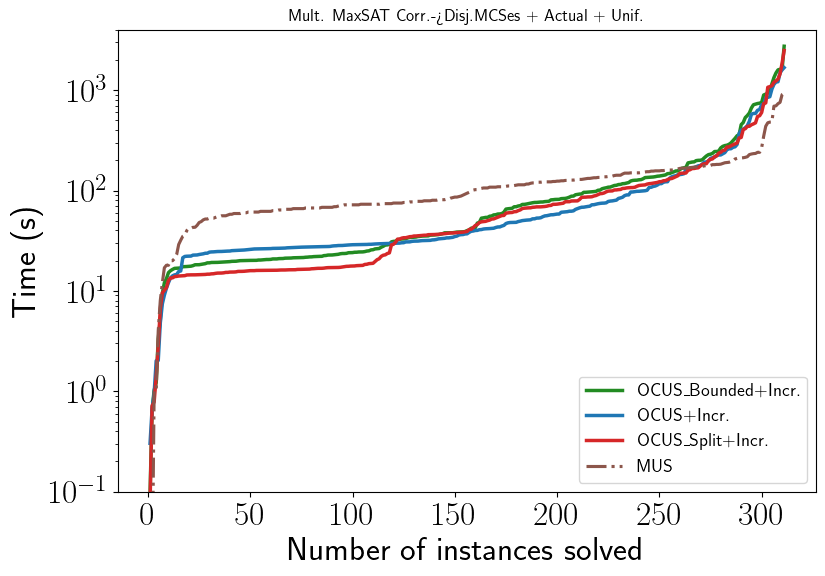

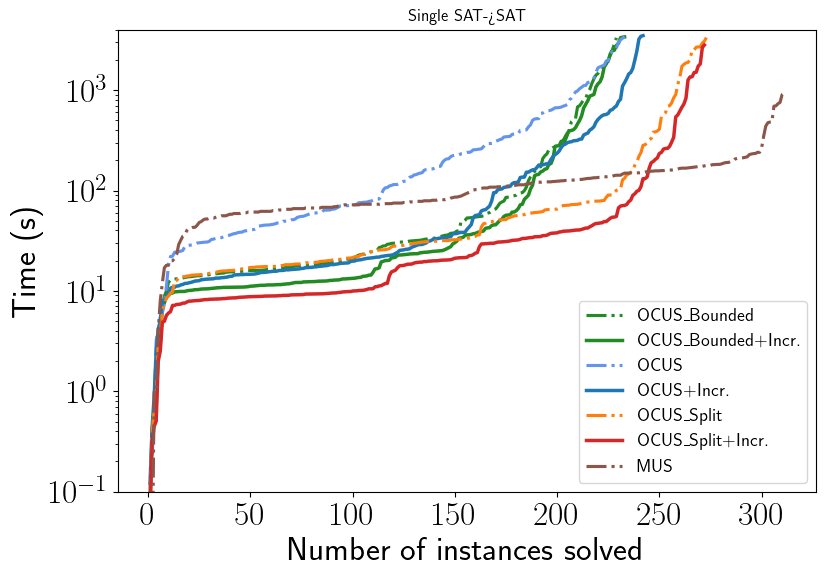

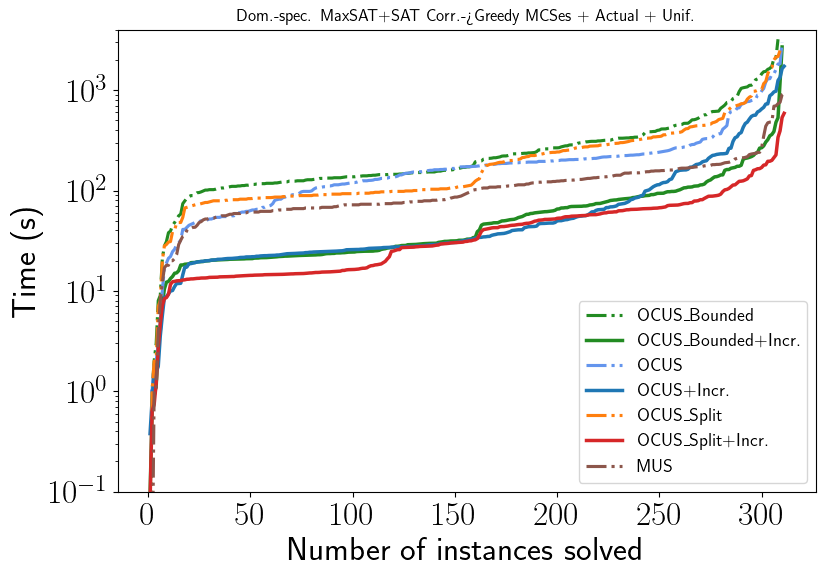

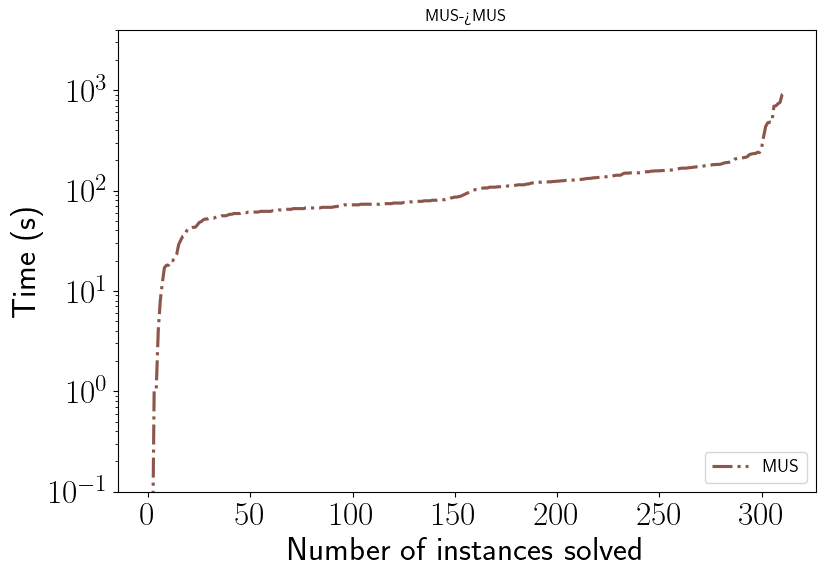

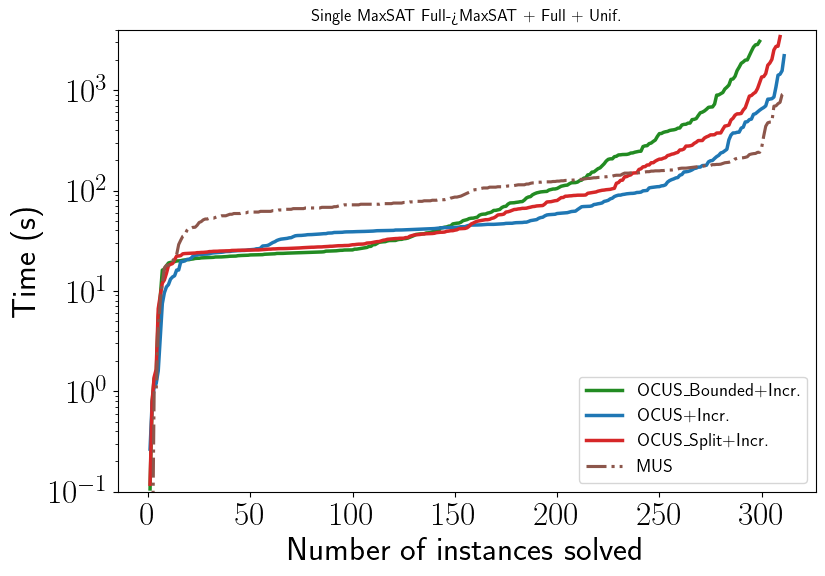

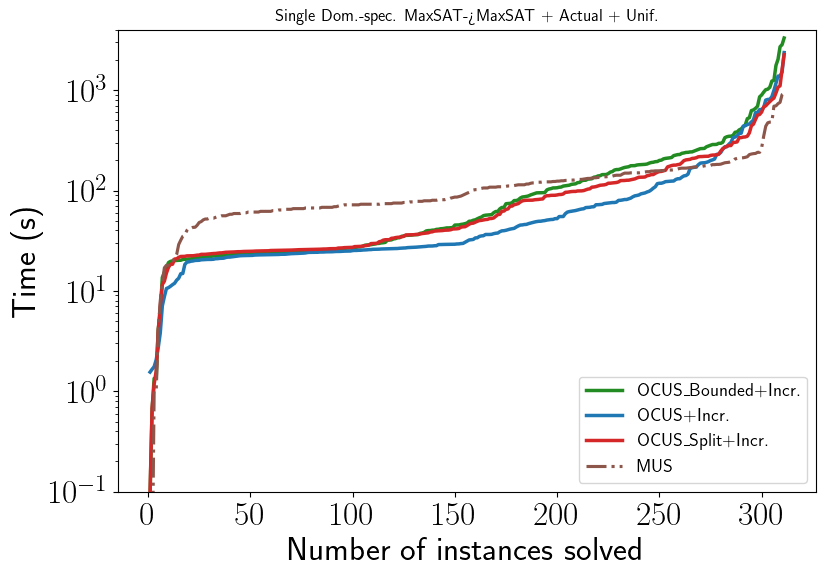

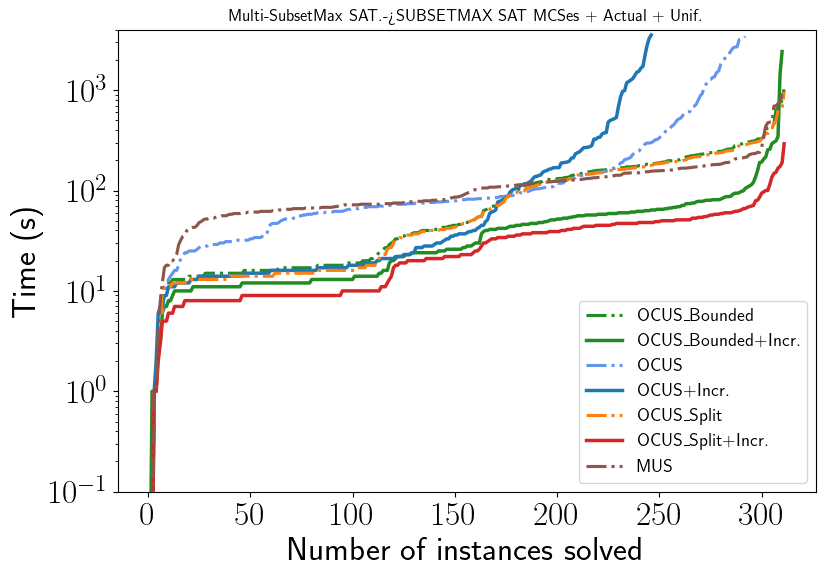

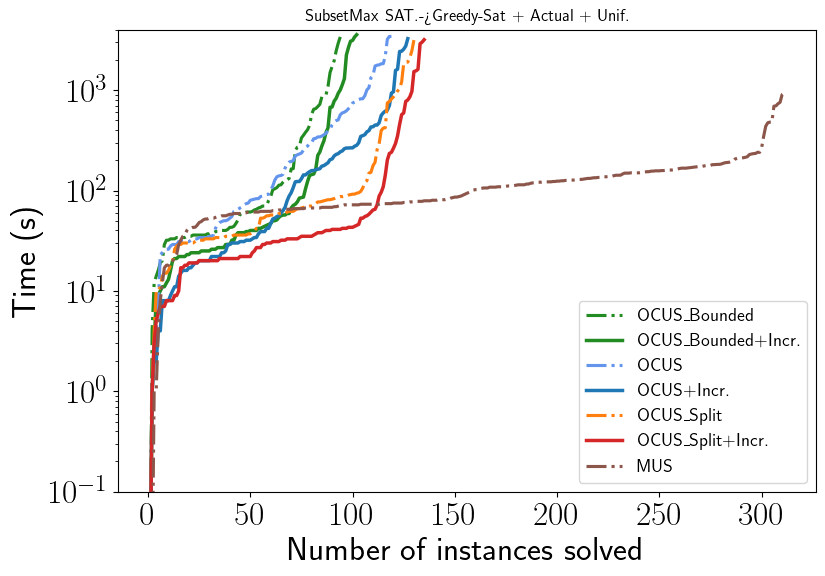

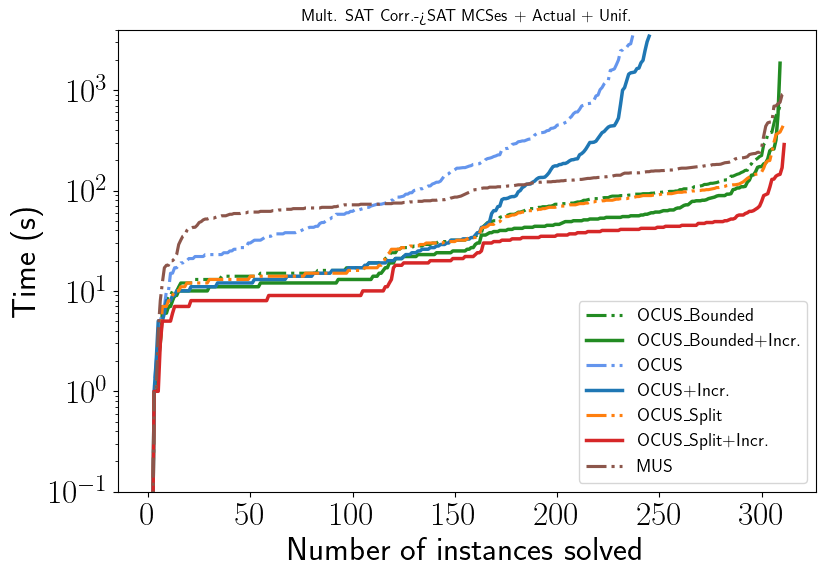

In [31]:
from collections import defaultdict

grow_renaming =  {
    'MaxSAT + Actual + Unif.': 'Single Dom.-spec. MaxSAT',
    'MaxSAT + Full + Unif.': 'Single MaxSAT Full',
    'SAT': 'Single SAT',
    'Greedy MCSes + Actual + Unif.': 'Dom.-spec. MaxSAT+SAT Corr.',
    'Disj.MCSes + Actual + Unif.': 'Mult. MaxSAT Corr.',
    'SAT MCSes + Actual + Unif.': "Mult. SAT Corr.",
    'SUBSETMAX SAT MCSes + Actual + Unif.': "Multi-SubsetMax SAT.",
    'Greedy-Sat + Actual + Unif.':'SubsetMax SAT.',
    "MUS": 'MUS'
}

### MUS Time to explain instances
mus_time_instances = sorted(list(df_all_grows[
    (df_all_grows["time_timedout"] == 0) & 
    (df_all_grows["explanation config"] == "MUS")
]["time_totalTime"]))

## COMPUTING ORDERING FOR ALL CONFIGS - "Greedy MCSes + Actual + Unif." as best grow
grow_config_timings = []

for conf in set(df_all_grows["explanation config"]):
    if conf == "MUS": continue
    time_instances = sorted(list(df_all_grows[
            (df_all_grows["time_timedout"] == 0) & 
            (df_all_grows["params_grow_config"] == "Greedy MCSes + Actual + Unif.") &
            (df_all_grows["explanation config"] == conf)
        ]["time_totalTime"]))
    
    grow_config_timings.append((conf, len(time_instances), max([10**8] + time_instances), time_instances))

## PUT MUS ALWAYS AS BOTTOM ON LEGEND
grow_sorted_ordering = [
    'OUSb',
    'OUSb+Lit. Incr. HS',
    'OCUS',
    'OCUS+Incr. HS',
    'OUS Iter.',
    'OUS Iter.+Lit. Incr. HS',
    'MUS',
]

color_matching = {
    'OCUS': 'cornflowerblue',
    'OUS Iter.': 'tab:orange',
    'OUS Iter.+Lit. Incr. HS': 'tab:red',
    'OUSb': 'forestgreen',
    'MUS': 'tab:brown',
    'OUSb+Lit. Incr. HS': 'forestgreen',
    'OCUS+Incr. HS': 'tab:blue'
}

epxl_conf_renaming = {
    'OCUS': 'OCUS',
    'OUS Iter.': 'OCUS\_Split',
    'OUS Iter.+Lit. Incr. HS': 'OCUS\_Split+Incr.',
    'OUSb': 'OCUS\_Bounded',
    'MUS': 'MUS',
    'OUSb+Lit. Incr. HS': 'OCUS\_Bounded+Incr.',
    'OCUS+Incr. HS': 'OCUS+Incr.'
}

for grow in set(df_all_grows["params_grow_config"]):
    
        
    grow_timings = {
        "MUS": (
            len(mus_time_instances), 
            max([1000000000] + mus_time_instances), 
            mus_time_instances
        )
    }
    
    
    ## select 
    df_selected_grow = df_all_grows[df_all_grows["params_grow_config"] == grow]
    for conf in set(df_selected_grow["explanation config"]):
        if conf == "MUS": continue
        
        time_instances = sorted(list(df_selected_grow[
            (df_selected_grow["time_timedout"] == 0) & 
            (df_selected_grow["explanation config"] == conf)
        ]["time_totalTime"]))
        
        if len(time_instances) == 0: continue
        
        grow_timings[conf] = (len(time_instances), max([1000000000] + time_instances), time_instances)

    
    ### BUILDING FIGURE

    
    plt.figure(figsize=(9, 6))
    for conf in grow_sorted_ordering:
        if conf not in grow_timings: continue

        _,_, time_instances = grow_timings[conf]
        if 'Incr' in conf:
            plt.plot(
                range(1, len(time_instances)+1), 
                time_instances, 
                label=epxl_conf_renaming[conf], 
                linewidth=2.5, 
                color=color_matching[conf]
            )
        else:
            plt.plot(
                range(1, len(time_instances)+1), 
                time_instances, 
                '-.', 
                label=epxl_conf_renaming[conf], 
                linewidth=2.25, 
                color=color_matching[conf]
            )
    
    #plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1.0, 0.55))
    plt.legend(fontsize=13, loc='lower right')#, bbox_to_anchor=(1.0, 0.55))
    plt.title(grow_renaming[grow] + "->" + grow)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylim([0.1, 4000])
    plt.yscale('log')
    
    plt.ylabel("Time (s)",fontsize=24)
    plt.xlabel("Number of instances solved",fontsize=24)
    output_filename = str(PATH_FIGURES_POST_PAPER / f"{datetime.now().strftime(f'rq3_cactus_r_%Y_%m_%d')}_{grow.replace(' ', '_').replace('+', '').replace('.','_')}.pdf")
    print(output_filename)
    plt.savefig(output_filename, bbox_inches='tight')

In [19]:
set(df_all_grows["params_grow_config"] )

{'Disj.MCSes + Actual + Unif.',
 'Greedy MCSes + Actual + Unif.',
 'Greedy-Sat + Actual + Unif.',
 'MUS',
 'MaxSAT + Actual + Unif.',
 'MaxSAT + Full + Unif.',
 'SAT',
 'SAT MCSes + Actual + Unif.',
 'SUBSETMAX SAT MCSes + Actual + Unif.'}

/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_cactus_log_2023_07_18_OCUSIncr_HS.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_cactus_log_2023_07_18_OCUS.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_cactus_log_2023_07_18_OUS_IterLit_Incr_HS.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_cactus_log_2023_07_18_OUS_Iter.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_cactus_log_2023_07_18_OUSbLit_Incr_HS.pdf
/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_cactus_log_2023_07_18_OUSb.pdf


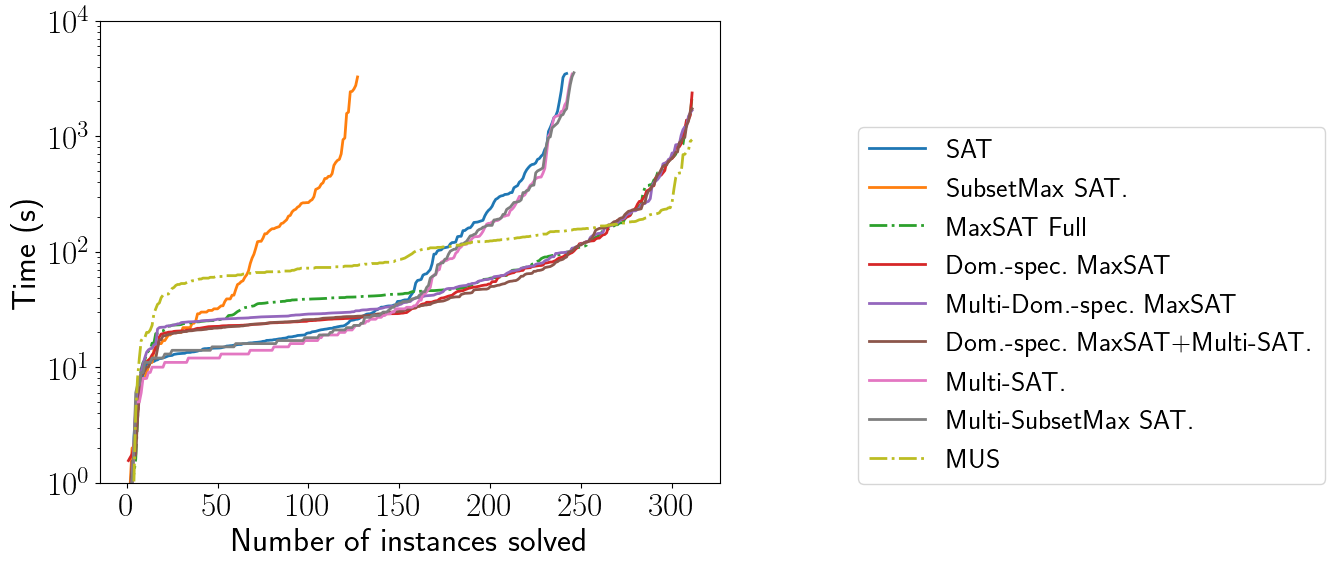

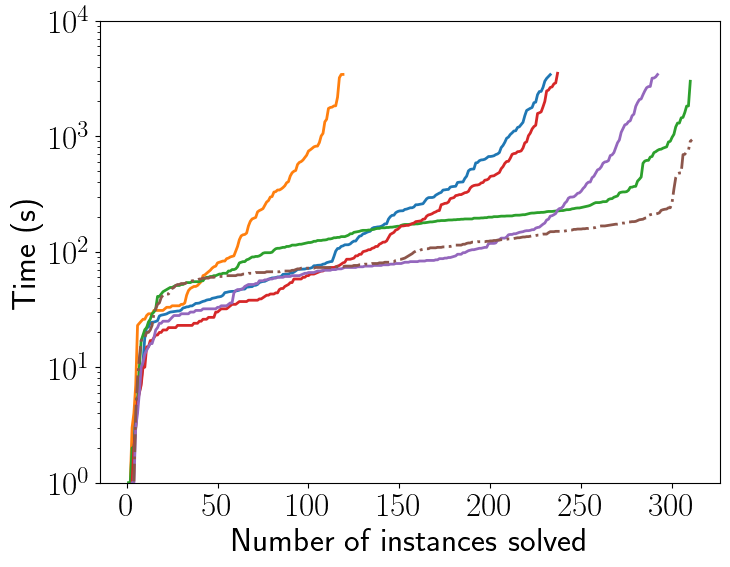

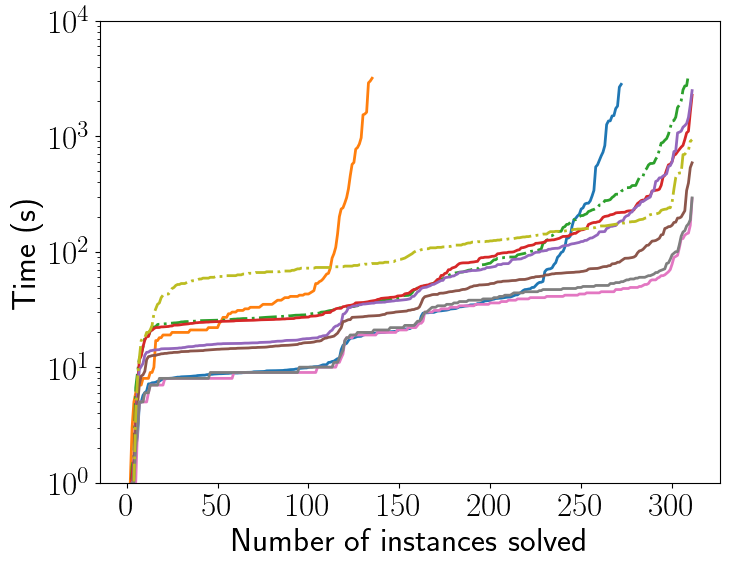

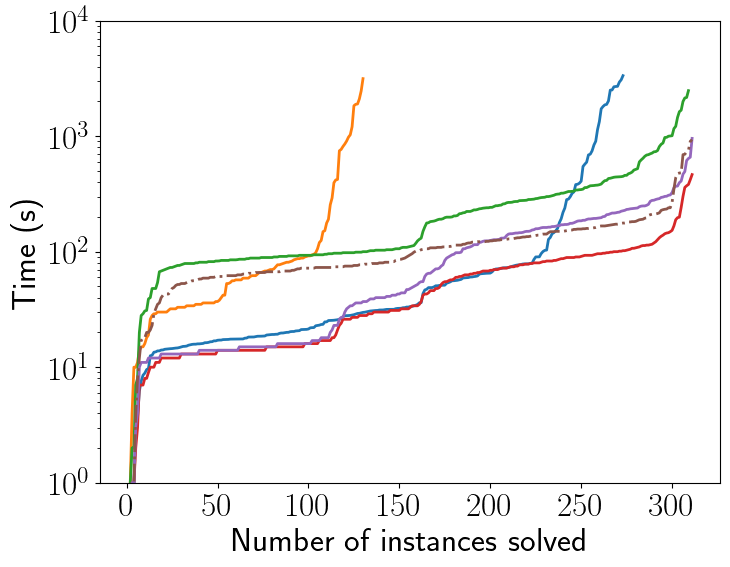

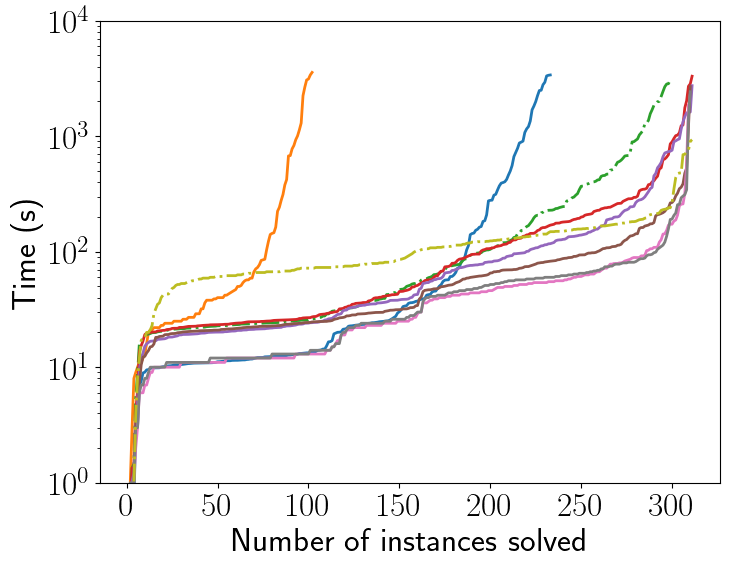

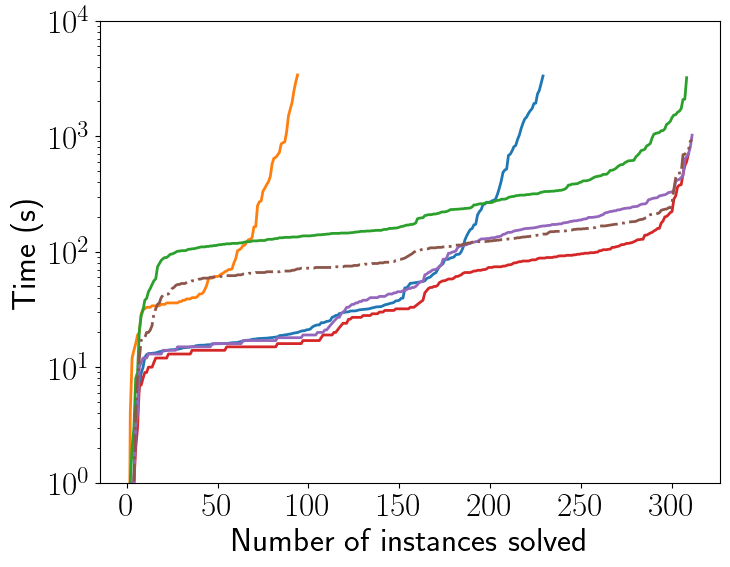

In [20]:
ignored_grow_configurations = [
    'Disj.MCSes + Full + Unif.',
    'Greedy MCSes + Full + Unif.' ,
    'No Grow'
]

grow_renaming =  {
    'MaxSAT + Actual + Unif.': 'Dom.-spec.~MaxSAT',
    'MaxSAT + Full + Unif.': 'MaxSAT Full',
    'SAT': 'SAT',
    'Greedy MCSes + Actual + Unif.': 'Dom.-spec.~MaxSAT+Multi-SAT.',
    'Disj.MCSes + Actual + Unif.': 'Multi-Dom.-spec.~MaxSAT',
    'SAT MCSes + Actual + Unif.': "Multi-SAT.",
    'SUBSETMAX SAT MCSes + Actual + Unif.': "Multi-SubsetMax SAT.",
    'Greedy-Sat + Actual + Unif.': 'SubsetMax SAT.',
}

conf_title = {
    "OUS Iter.+Lit. Incr. HS": "Expl.-Spec. OCUS+Incr.",
    "OCUS": "OCUS",
    "OUS Iter.": "Expl.-Spec. OCUS",
    "OCUS+Incr. HS": "OCUS+Incr.",
    "OUSb": "Bounded OUS",
    "OUSb+Lit. Incr. HS": "Bounded OUS+Incr.",
}

selected_grow_configurations = [
    c for c in set(df_all_grows["params_grow_config"]) if c not in ignored_grow_configurations
]

select_explanation_configs = list(set(df_all_grows["explanation config"]))

mus_time_instances = time_instances = sorted(list(df_all_grows[
    (df_all_grows["time_timedout"] == 0) & 
    (df_all_grows["explanation config"] == "MUS")
]["time_totalTime"]))

## COMPUTING ORDERING FOR ALL CONFIGS - "Greedy MCSes + Actual + Unif." as best grow
grow_config_timings = []

for grow in selected_grow_configurations:
    if grow == "MUS": continue
    time_instances = sorted(list(df_all_grows[
            (df_all_grows["time_timedout"] == 0) & 
            (df_all_grows["params_grow_config"] == grow) &
            (df_all_grows["explanation config"] == "OUS Iter.+Lit. Incr. HS")
        ]["time_totalTime"]))
    
    grow_config_timings.append((grow, len(time_instances), max([10**8] + time_instances), time_instances))

## PUT MUS ALWAYS AS BOTTOM ON LEGEND
grow_sorted_ordering = [
    'SAT', 
    'Greedy-Sat + Actual + Unif.',
    'MaxSAT + Full + Unif.', 
    'MaxSAT + Actual + Unif.', 
    'Disj.MCSes + Actual + Unif.', 
    'Greedy MCSes + Actual + Unif.', 
    'SAT MCSes + Actual + Unif.',
    'SUBSETMAX SAT MCSes + Actual + Unif.',

    'MUS']

for conf in select_explanation_configs:
    if conf == "MUS": continue
      

    plt.figure(figsize=(8,6))
    
    explanation_timing = {
        "MUS": (len(mus_time_instances), max([1000000000] + mus_time_instances), mus_time_instances)
    }

    for grow in selected_grow_configurations:
        #
        if grow == "MUS": continue

        time_instances = sorted(list(df_all_grows[
            (df_all_grows["time_timedout"] == 0) & 
            (df_all_grows["params_grow_config"] == grow) &
            (df_all_grows["explanation config"] == conf)
        ]["time_totalTime"]))
        
        if len(time_instances) == 0: continue
        explanation_timing[grow] = (len(time_instances), max([1000000000] + time_instances), time_instances)

    base_grows = ['Dom.-spec. MaxSAT', 'MaxSAT Full', 'No grow']
    for grow in grow_sorted_ordering:
        if grow not in explanation_timing: continue
        
        _,_, time_instances = explanation_timing[grow]
        renamed_grow = grow_renaming[grow] if (grow in grow_renaming) else grow
        if renamed_grow == "MUS" or renamed_grow in base_grows:
            plt.plot(range(1, len(time_instances)+1), time_instances, '-.', label=renamed_grow, linewidth=2)
        else:
            plt.plot(range(1, len(time_instances)+1), time_instances, label=renamed_grow, linewidth=2)
#     plt.legend(fontsize=18, loc='lower right')#
    if conf == "OCUS+Incr. HS":
        plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1.2, 0.8))

#     def export_legend(legend, filename=str(PATH_FIGURES_POST_PAPER /"legend.png")):
#         fig  = legend.figure
#         fig.canvas.draw()
#         bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         fig.savefig(filename, dpi="figure", bbox_inches=bbox)

#     export_legend(
#         legend,
#         filename=str(PATH_FIGURES_POST_PAPER /f"legend_{conf.replace(' ', '_').replace('+', '').replace('.','')}.pdf"))
    #TODO: add description outside of plot
#     plt.title(f'{conf_title[conf]}',fontsize=22)
#     print(conf)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.yscale('log')
    plt.ylabel("Time (s)",fontsize=24)
    plt.ylim([1, 10000])
    plt.xlabel("Number of instances solved",fontsize=24)
    output_filename = str(PATH_FIGURES_POST_PAPER / f"{datetime.now().strftime(f'rq2_cactus_log_%Y_%m_%d')}_{conf.replace(' ', '_').replace('+', '').replace('.','')}.pdf")
    print(output_filename)
    #print(str(PATH_FIGURES_POST_PAPER / f"{datetime.now().strftime(f'leg_rq3_cactus_r_%Y_%m_%d')}_{grow.replace(' ', '_').replace('+', '')}.pdf"))
    plt.savefig(output_filename, bbox_inches='tight')

## For the best configuration - Corr Subsets - generate cumulative explanation time

selecting the Puzzles families:

saving to path= /Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/rq2_corr_subsets_2023_06_23.pdf


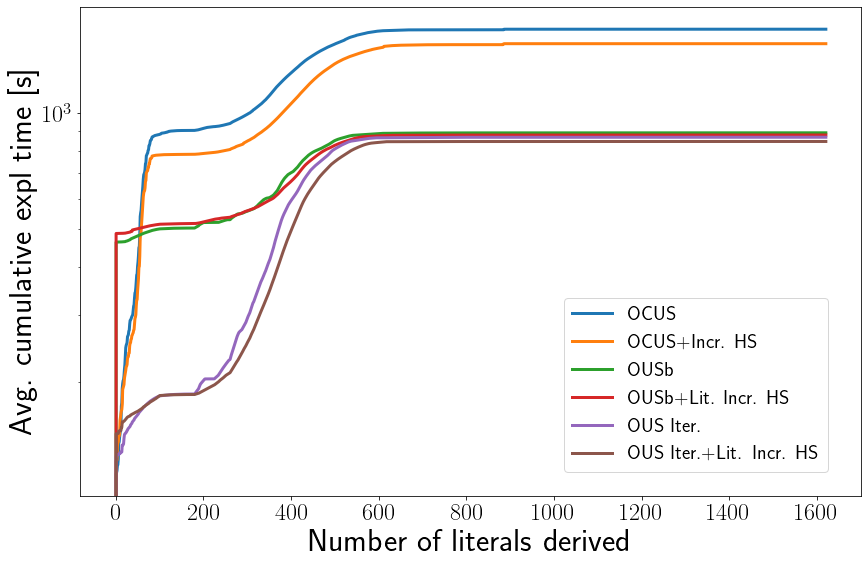

In [38]:
df_greedy_corr_subsets = df_all_grows[
    (df_all_grows["params_grow_config"] == "SAT MCSes + Actual + Unif.")
]
d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_greedy_corr_subsets, column_name="explanation config", ignored=[])
plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    ordering=ordering,
#     mapping=grow_renamed,
    figsize=(14, 9), 
    #with_line = 3600,
    ylog=True,
    #ylim = (0, 400),
    loc=(0.62, 0.05),
    #next_to_graph=True,
    figure_path=PATH_FIGURES_POST_PAPER / datetime.now().strftime(f"rq2_corr_subsets_%Y_%m_%d.pdf"),
)

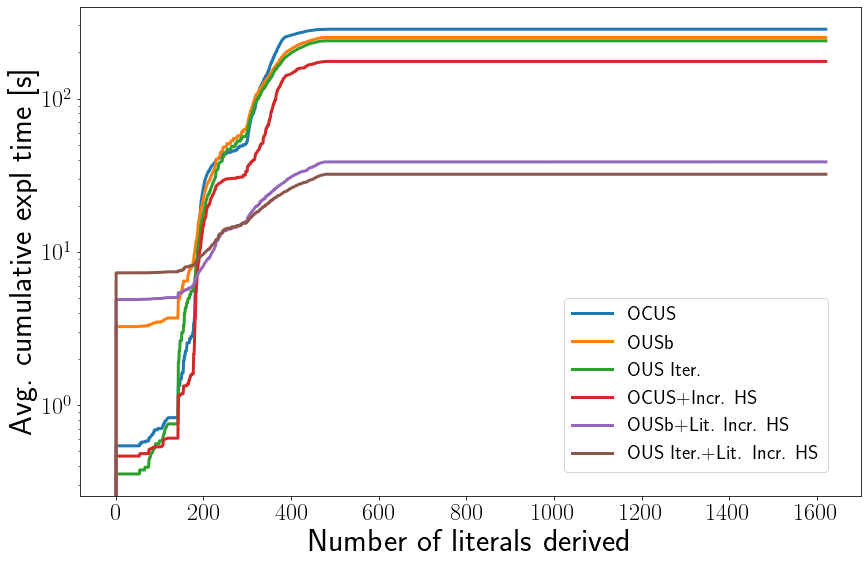

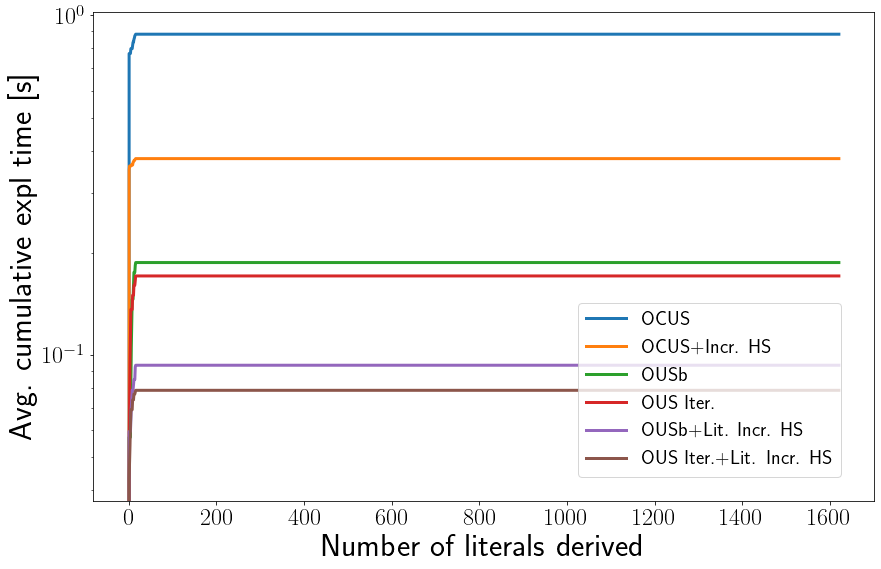

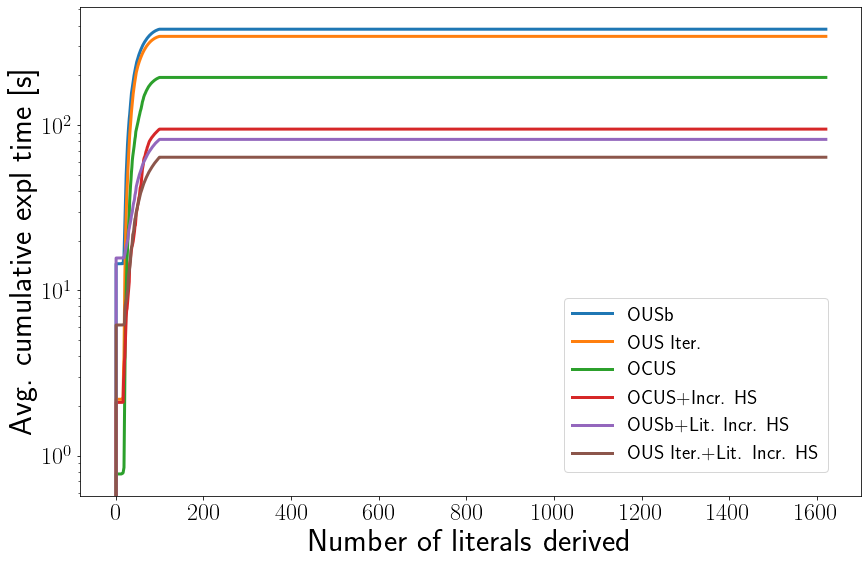

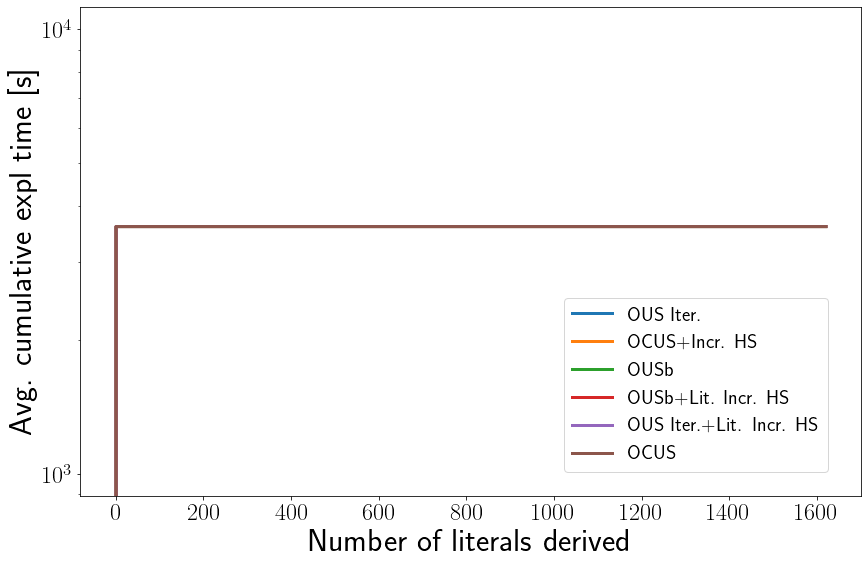

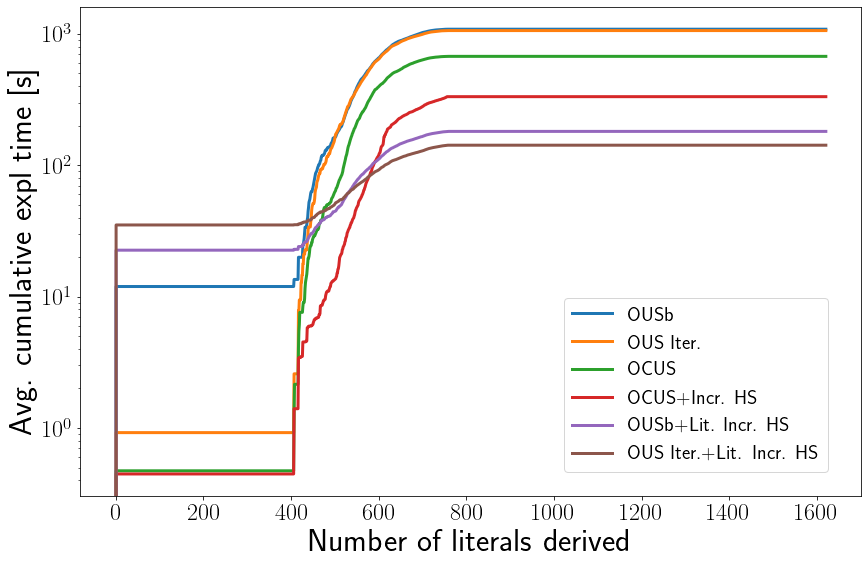

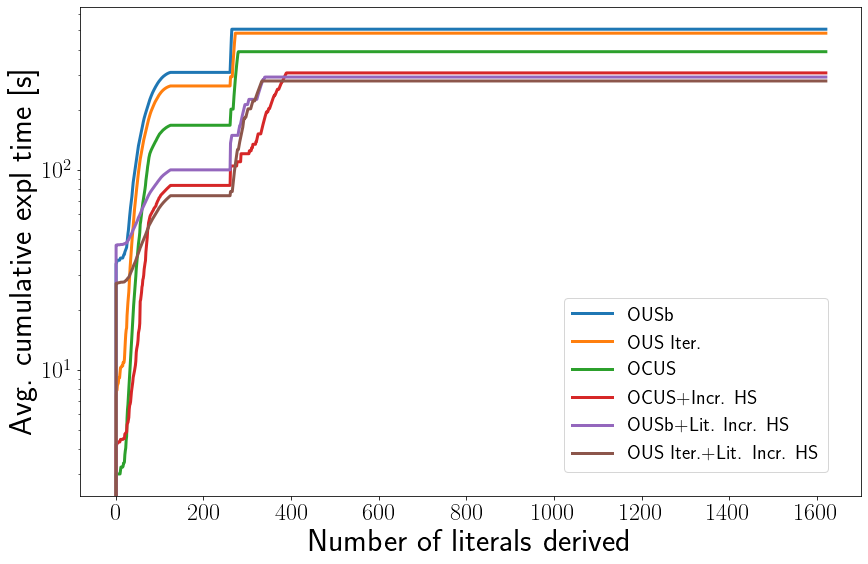

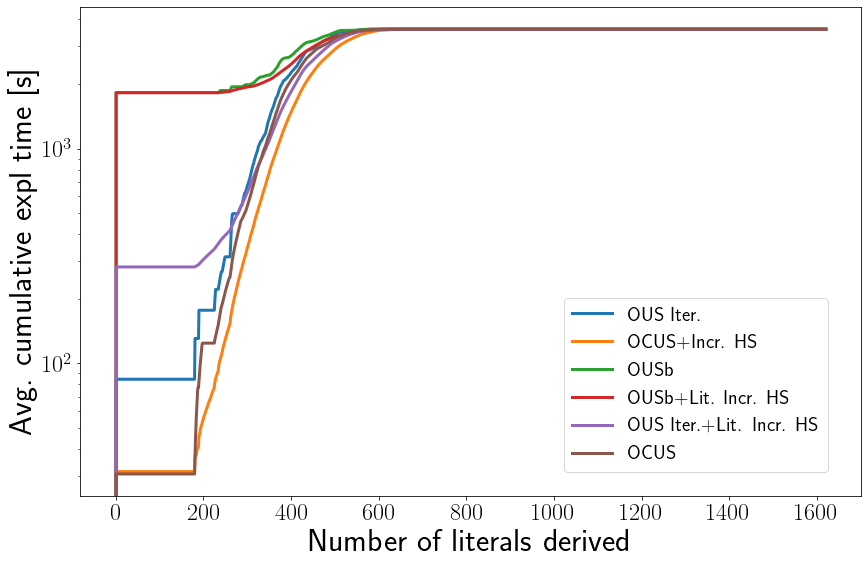

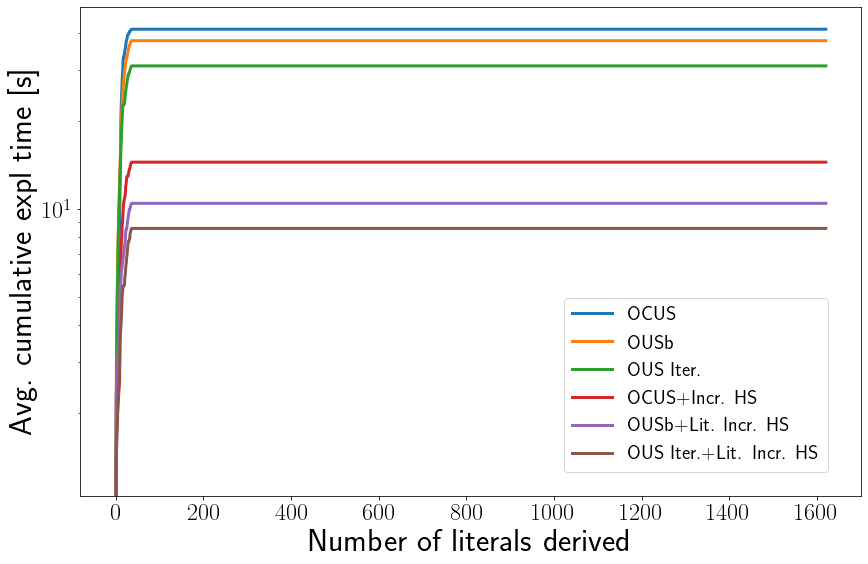

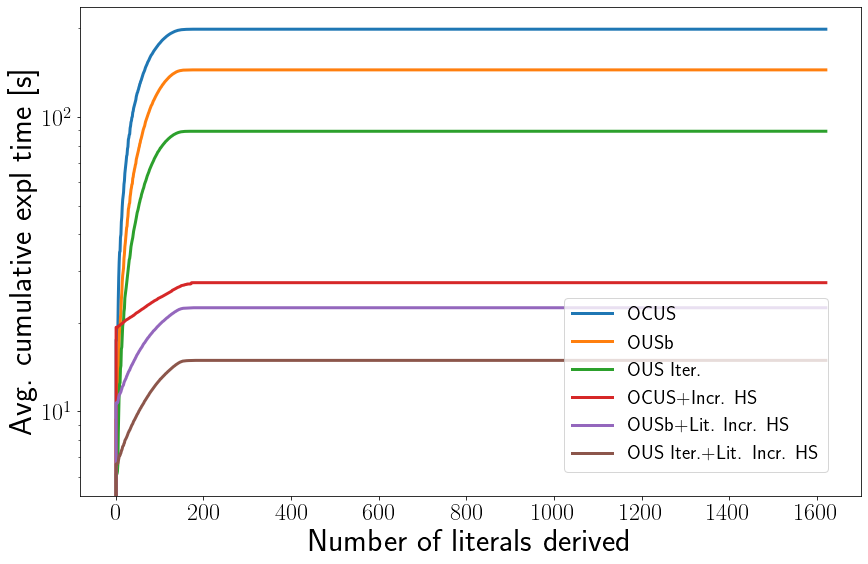

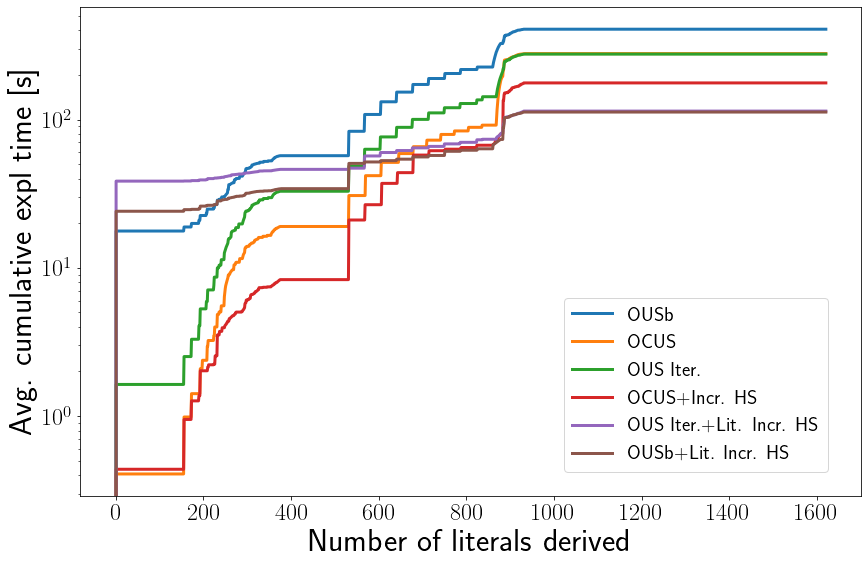

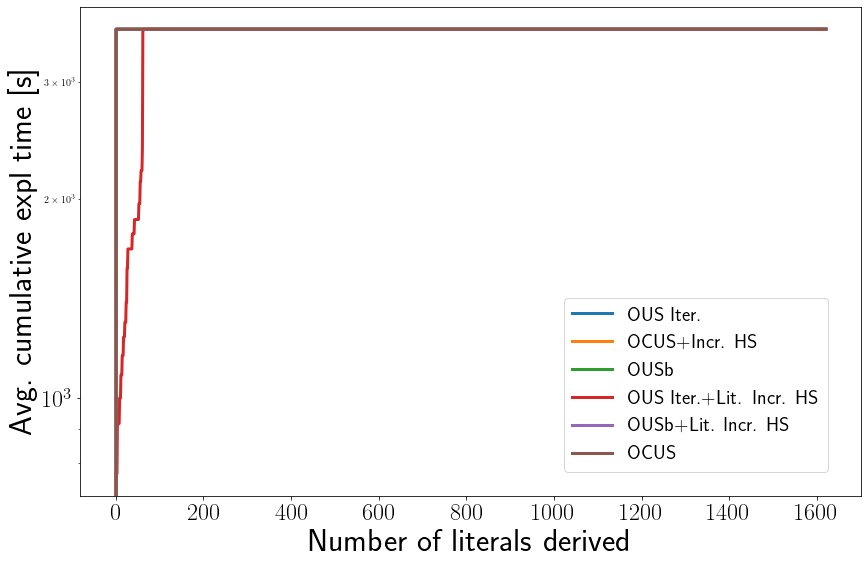

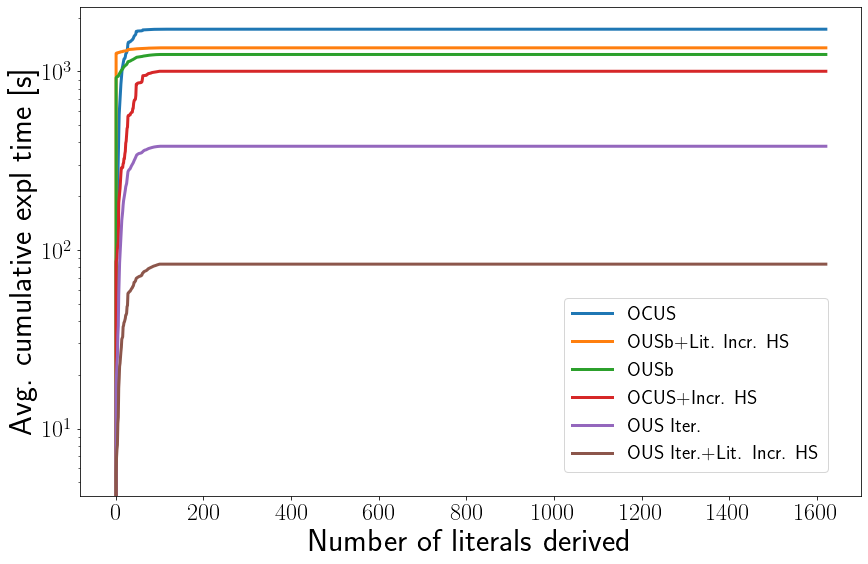

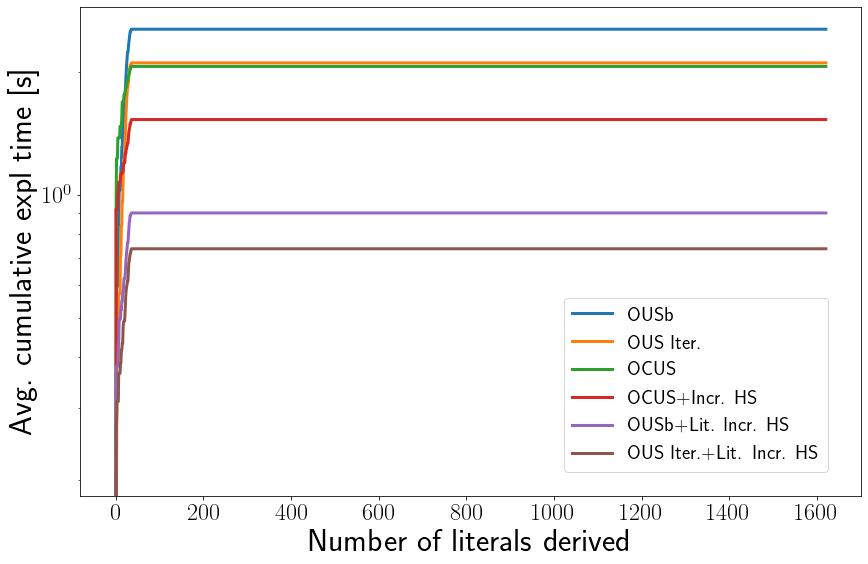

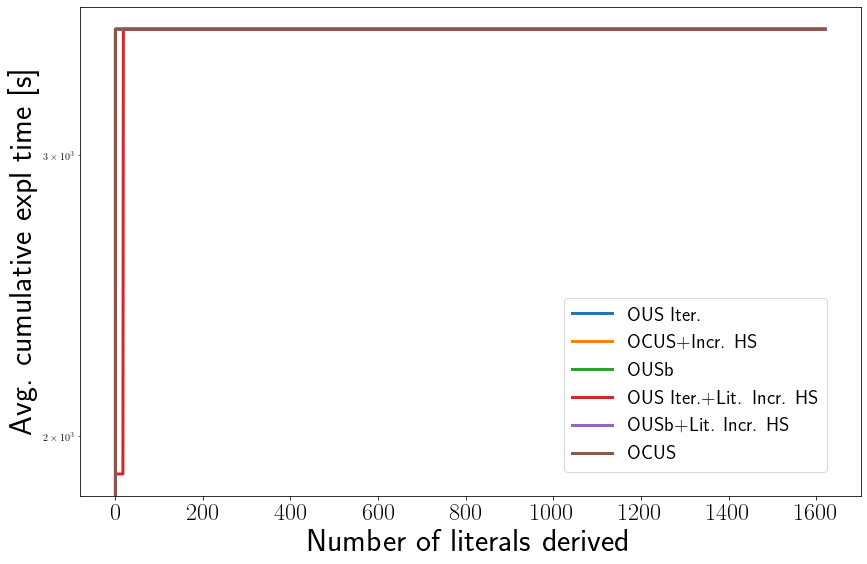

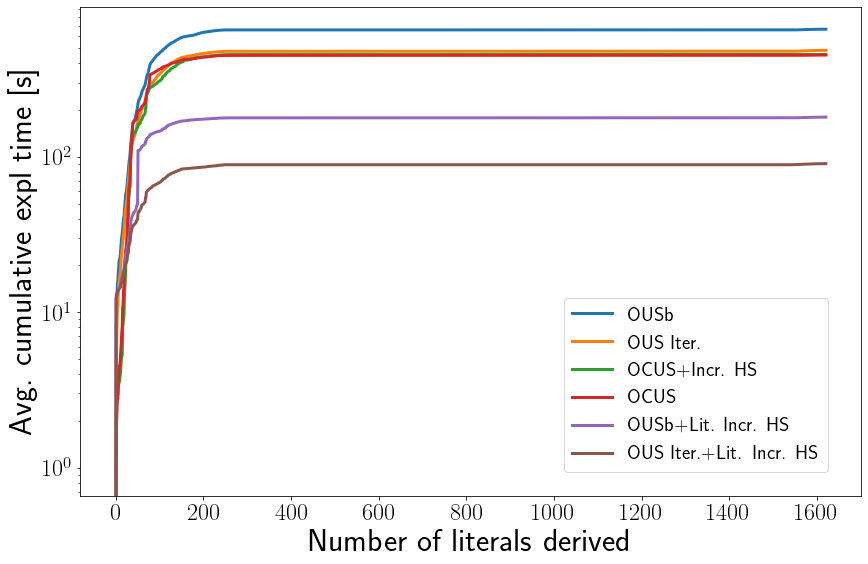

In [39]:
for puzzle_family in set(df_greedy_corr_subsets["instance_family"]):
    df_greedy_corr_subsets_puzzle_family = df_all_grows[
        (df_all_grows["params_grow_config"] == "Greedy MCSes + Actual + Unif.") & 
        (df_all_grows["instance_family"] == puzzle_family)
    ]
    from IPython.display import display, HTML
    chart = HTML(f'<h1>{puzzle_family.capitalize()}</h1>')
    # or chart = charts.plot(...)
    display(chart)
    d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_greedy_corr_subsets_puzzle_family, column_name="explanation config", ignored=[])
    plot_derived_lits_avg_time(
        d_cumul_avg_time_incr, 
        ordering=ordering,
    #     mapping=grow_renamed,
        figsize=(14, 9), 
        ylog=True,
        #with_line = 3600,
        #ylim = (0, 400),
        loc=(0.62, 0.05),
        #next_to_graph=True,
    #     figure_path=PATH_FIGURES_POST_PAPER / datetime.now().strftime(f"rq2_grow_{expl_config}_%Y_%m_%d.pdf"),
    )

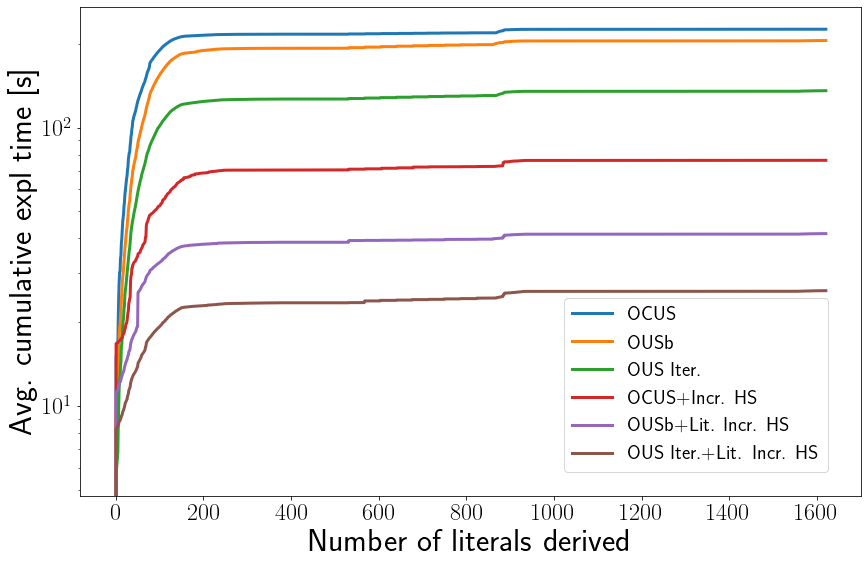

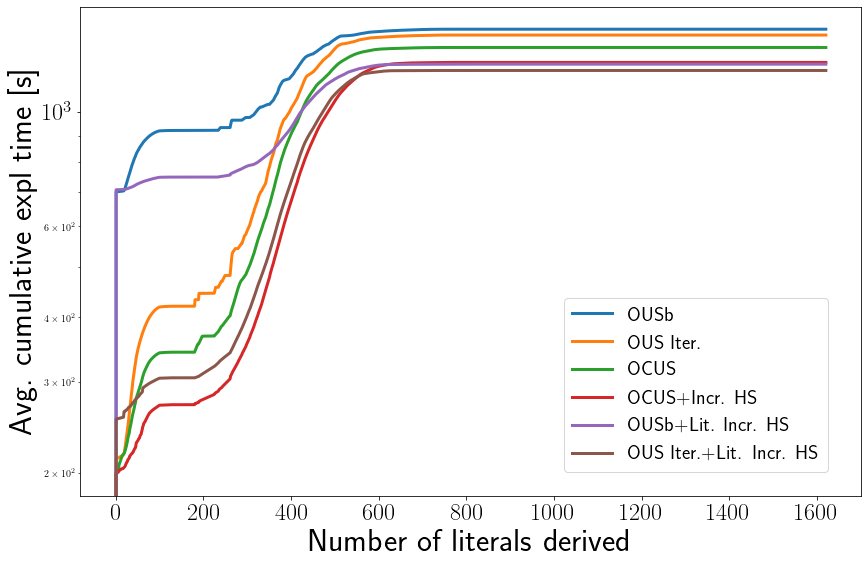

In [40]:
for dataset in set(df_greedy_corr_subsets["instance_dataset"]):
    df_greedy_corr_subsets_dataset = df_all_grows[
        (df_all_grows["params_grow_config"] == "Greedy MCSes + Actual + Unif.") & 
        (df_all_grows["instance_dataset"] == dataset)
    ]
    from IPython.display import display, HTML
    chart = HTML(f'<h1>{dataset.capitalize()}</h1>')
    # or chart = charts.plot(...)
    display(chart)
    d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_greedy_corr_subsets_dataset, column_name="explanation config", ignored=[])
    plot_derived_lits_avg_time(
        d_cumul_avg_time_incr, 
        ordering=ordering,
    #     mapping=grow_renamed,
        figsize=(14, 9), 
        ylog=True,
        #with_line = 3600,
        #ylim = (0, 400),
        loc=(0.62, 0.05),
        #next_to_graph=True,
    #     figure_path=PATH_FIGURES_POST_PAPER / datetime.now().strftime(f"rq2_grow_{expl_config}_%Y_%m_%d.pdf"),
    )

## Checking if all instances have a conifugration run

checking if there are missing instances that are in MUS but not in other instances

In [41]:
wrongly_timedout = check_wrongly_timedout(df_all_grows)

if len(wrongly_timedout) > 0:
    print(f"{wrongly_timedout=}")

wrongly_non_timedout_instances, wrongly_non_timedout = check_wrongly_not_timedout(df_all_grows)

if len(wrongly_non_timedout) > 0 or len(wrongly_non_timedout_instances) > 0:
    print(f"{wrongly_non_timedout=}")
    print(f"\n{wrongly_non_timedout_instances=}")

wrongly_timedout=[('/data/brussel/101/vsc10143/hpc_experiments2/experiments/data/output/RQ2_SAT_CORR_SUBSETS/2022060210/subsetmax_correction_subsets__results_1447.json', 100, 100), ('/data/brussel/101/vsc10143/hpc_experiments2/experiments/data/output/RQ2_DEMYSTIFY_PUZZLES_MAXSAT_FULL/2022021708/RQ2_DEMYSTIFY_PUZZLES__results_449.json', 100, 100)]


## SAT and MUS

In [42]:
# df_all_grows
df_mus_all_grows_selected = df_all_grows[
    (df_all_grows["params_grow_config"].isin(["SAT MCSes + Actual + Unif.", "MUS"])) & 
    (~df_all_grows["time_timedout"])
]

## df_corr_selected
# display(df_mus_all_grows_selected.groupby(by=["params_explanation_computer","params_grow_config"]).count())

df_corr_selected_grouped = df_mus_all_grows_selected.groupby(by=["params_explanation_computer", "params_grow_config"]).agg(
    t=("tot_time_explain" , lambda x: round(mean_ignore_zeros(x), 2)),
    f=("time_timedout", lambda x: f"[{str(len(x) - np.sum(x)).zfill(3)} / {len(x)}]"),
    avg_opt=("%time_opt2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_opt=("%time_opt2" , lambda x: round(np.std(x), 2)),
    avg_sat=("%time_sat2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_sat=("%time_sat2" ,lambda x: round(np.std(x), 2)),
    avg_grow=("%time_grow2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_grow=("%time_grow2" , lambda x: round(np.std(x), 2)),
    avg_disj_mcs=("%time_disj_mcs2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_disj_mcs=("%time_disj_mcs2" , lambda x: round(np.std(x), 2)),
    avg_remaining=("%time_remaining2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_remaining=("%time_remaining2" , lambda x: round(np.std(x), 2)),
    sum_t_opt=("tot_time_opt" , lambda x: sum(x)),
    sum_t_sat=("tot_time_sat" , lambda x: sum(x)),
    sum_t_grow=("tot_time_grow" , lambda x: sum(x)),
    avg_n_opt=("tot_n_opt" , lambda x: round(mean_ignore_zeros(x))),
    avg_n_sat=("tot_n_sat" , lambda x: round(mean_ignore_zeros(x))),
    avg_n_grow=("tot_n_grow" , lambda x: round(mean_ignore_zeros(x))),
    tot_n_opt=("tot_n_opt" , lambda x: sum(x)),
    tot_n_sat=("tot_n_sat" , lambda x: sum(x)),
    tot_n_grow=("tot_n_grow" , lambda x: sum(x)),
    avg_n_hs=("tot_n_hs" , lambda x: round(mean_ignore_zeros(x))),
    cnt = ("time_timedout", "count")
)

df_temp = df_corr_selected_grouped.reset_index()
for k in ["opt", "sat", "grow", "disj_mcs", "remaining"]:
    df_temp[k] = df_temp.apply(lambda row: None, axis=1)
    df_temp["%"+k] = df_temp.apply(lambda row: None, axis=1)

df_temp["avg_t_opt"] = df_temp.apply(
    lambda row: round(row["sum_t_opt"]/row['tot_n_opt'], 4) if row["tot_n_opt"] !=0 else 0, axis=1)
df_temp["avg_t_sat"] = df_temp.apply(
    lambda row: round(row['sum_t_sat']/row['tot_n_sat']  if row["tot_n_sat"] !=0 else 0, 4), axis=1)
df_temp["avg_t_grow"] = df_temp.apply(
    lambda row: round(row['sum_t_grow']/row['tot_n_grow']  if row["tot_n_grow"] !=0 else 0, 4), axis=1)

for index,row in df_temp.iterrows():
    for k in ["opt", "sat", "grow", "disj_mcs", "remaining"]:
        df_temp.at[index,k]= f'{row["avg_"+k]}% [+/- {row["std_"+k]}%]'
        df_temp.at[index,"%"+k]= f'{row["avg_"+k]}%'

renaming_expl_config = {
    "MUS": "MUS",
    "OCUS":"OCUS+Incr. HS",
    "OCUS_NOT_INCREMENTAL":"OCUS",
    "OUS_INCREMENTAL_NAIVE":"OUSb+Lit. Incr. HS",
    "OUS_INCREMENTAL_NAIVE_PARALLEL": "OUS Iter.+Lit. Incr. HS",
    "OUS_NAIVE_PARALLEL":"OUS Iter.",
    "OUS_SS": "OUSb"
}
        
df_temp["expl_config"] = df_temp.apply(
    lambda row: renaming_expl_config[row['params_explanation_computer']], axis=1)

percentage_exec_time_ous = df_temp[
        df_temp["expl_config"] != "bla"
    ][
    ["expl_config",#'params_grow_config',
     "t",
     "f",
     "%opt", 
     "%sat", 
     "%grow", 
     "%disj_mcs",
     #"%remaining",
     "avg_n_hs"
     #'avg_t_opt', 
     #'avg_n_opt', 
     #'avg_t_sat',
     #'avg_n_sat', 
     #'avg_t_grow',
     #'avg_n_grow'
    ]].sort_values(["avg_n_hs"], ascending=[False])
display(percentage_exec_time_ous)
print(percentage_exec_time_ous.to_latex(index=False))

# df_sat_ignored_instances.groupby(by=["params_explanation_computer"]).sum()

,expl_config,t,f,%opt,%sat,%grow,%disj_mcs,avg_n_hs
6,OUSb,62.35,[309 / 309],59.1%,9.2%,0%,31.7%,26902
5,OUS Iter.,57.15,[311 / 311],64.28%,5.48%,0%,30.24%,25334
2,OCUS,287.11,[237 / 237],91.91%,3.69%,0%,4.4%,5271
3,OUSb+Lit. Incr. HS,46.67,[309 / 309],91.6%,5.32%,0%,3.08%,1432
4,OUS Iter.+Lit. Incr. HS,28.42,[311 / 311],92.22%,2.08%,0%,5.71%,1418
1,OCUS+Incr. HS,169.86,[245 / 245],98.04%,1.09%,0%,0.87%,406
0,MUS,122.04,[311 / 311],0.0%,0.0%,0%,0.0%,0


\begin{tabular}{lrlllllr}
\toprule
            expl\_config &      t &           f &   \%opt &  \%sat & \%grow & \%disj\_mcs &  avg\_n\_hs \\
\midrule
                   OUSb &  62.35 & [309 / 309] &  59.1\% &  9.2\% &    0\% &     31.7\% &     26902 \\
              OUS Iter. &  57.15 & [311 / 311] & 64.28\% & 5.48\% &    0\% &    30.24\% &     25334 \\
                   OCUS & 287.11 & [237 / 237] & 91.91\% & 3.69\% &    0\% &      4.4\% &      5271 \\
     OUSb+Lit. Incr. HS &  46.67 & [309 / 309] &  91.6\% & 5.32\% &    0\% &     3.08\% &      1432 \\
OUS Iter.+Lit. Incr. HS &  28.42 & [311 / 311] & 92.22\% & 2.08\% &    0\% &     5.71\% &      1418 \\
          OCUS+Incr. HS & 169.86 & [245 / 245] & 98.04\% & 1.09\% &    0\% &     0.87\% &       406 \\
                    MUS & 122.04 & [311 / 311] &   0.0\% &  0.0\% &    0\% &      0.0\% &         0 \\
\bottomrule
\end{tabular}



/var/folders/7x/w1gprqxx2xx6tk7j178kv9hr0000gp/T/ipykernel_11934/1493847638.py:86: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(percentage_exec_time_ous.to_latex(index=False))


## MaxSAT Grow with SAT and MUS

In [43]:
# df_all_grows
df_mus_all_grows_selected = df_all_grows[
    (df_all_grows["params_grow_config"].isin(["SAT", "MUS"])) & 
    (~df_all_grows["time_timedout"])
]

## df_corr_selected
# display(df_mus_all_grows_selected.groupby(by=["params_explanation_computer","params_grow_config"]).count())

df_corr_selected_grouped = df_mus_all_grows_selected.groupby(by=["params_explanation_computer", "params_grow_config"]).agg(
    t=("tot_time_explain" , lambda x: round(mean_ignore_zeros(x), 2)),
    f=("time_timedout", lambda x: f"[{str(len(x) - np.sum(x)).zfill(3)} / {len(x)}]"),
    avg_opt=("%time_opt2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_opt=("%time_opt2" , lambda x: round(np.std(x), 2)),
    avg_sat=("%time_sat2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_sat=("%time_sat2" ,lambda x: round(np.std(x), 2)),
    avg_grow=("%time_grow2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_grow=("%time_grow2" , lambda x: round(np.std(x), 2)),
    avg_disj_mcs=("%time_disj_mcs2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_disj_mcs=("%time_disj_mcs2" , lambda x: round(np.std(x), 2)),
    avg_remaining=("%time_remaining2" , lambda x: round(mean_ignore_zeros(x), 2)),
    std_remaining=("%time_remaining2" , lambda x: round(np.std(x), 2)),
    sum_t_opt=("tot_time_opt" , lambda x: sum(x)),
    sum_t_sat=("tot_time_sat" , lambda x: sum(x)),
    sum_t_grow=("tot_time_grow" , lambda x: sum(x)),
    avg_n_opt=("tot_n_opt" , lambda x: round(mean_ignore_zeros(x))),
    avg_n_sat=("tot_n_sat" , lambda x: round(mean_ignore_zeros(x))),
    avg_n_grow=("tot_n_grow" , lambda x: round(mean_ignore_zeros(x))),
    tot_n_opt=("tot_n_opt" , lambda x: sum(x)),
    tot_n_sat=("tot_n_sat" , lambda x: sum(x)),
    tot_n_grow=("tot_n_grow" , lambda x: sum(x)),
    avg_n_hs=("tot_n_hs" , lambda x: round(mean_ignore_zeros(x))),
    cnt = ("time_timedout", "count")
)

df_temp = df_corr_selected_grouped.reset_index()
for k in ["opt", "sat", "grow", "disj_mcs", "remaining"]:
    df_temp[k] = df_temp.apply(lambda row: None, axis=1)
    df_temp["%"+k] = df_temp.apply(lambda row: None, axis=1)

df_temp["avg_t_opt"] = df_temp.apply(
    lambda row: round(row["sum_t_opt"]/row['tot_n_opt'], 4) if row["tot_n_opt"] !=0 else 0, axis=1)
df_temp["avg_t_sat"] = df_temp.apply(
    lambda row: round(row['sum_t_sat']/row['tot_n_sat']  if row["tot_n_sat"] !=0 else 0, 4), axis=1)
df_temp["avg_t_grow"] = df_temp.apply(
    lambda row: round(row['sum_t_grow']/row['tot_n_grow']  if row["tot_n_grow"] !=0 else 0, 4), axis=1)

for index,row in df_temp.iterrows():
    for k in ["opt", "sat", "grow", "disj_mcs", "remaining"]:
        df_temp.at[index,k]= f'{row["avg_"+k]}% [+/- {row["std_"+k]}%]'
        df_temp.at[index,"%"+k]= f'{row["avg_"+k]}%'

renaming_expl_config = {
    "MUS": "MUS",
    "OCUS":"OCUS+Incr. HS",
    "OCUS_NOT_INCREMENTAL":"OCUS",
    "OUS_INCREMENTAL_NAIVE":"OUSb+Lit. Incr. HS",
    "OUS_INCREMENTAL_NAIVE_PARALLEL": "OUS Iter.+Lit. Incr. HS",
    "OUS_NAIVE_PARALLEL":"OUS Iter.",
    "OUS_SS": "OUSb"
}
        
df_temp["expl_config"] = df_temp.apply(
    lambda row: renaming_expl_config[row['params_explanation_computer']], axis=1)

percentage_exec_time_ous = df_temp[
        df_temp["expl_config"] != "bla"
    ][
    ["expl_config",#'params_grow_config',
     "t",
     "f",
     "%opt", 
     "%sat", 
     #"%grow", 
     "%disj_mcs",
     #"%remaining",
     "avg_n_hs"
     #'avg_t_opt', 
     #'avg_n_opt', 
     #'avg_t_sat',
     #'avg_n_sat', 
     #'avg_t_grow',
     #'avg_n_grow'
    ]].sort_values(["avg_n_hs"], ascending=[False])
display(percentage_exec_time_ous)
print(percentage_exec_time_ous.to_latex(index=False))

# df_sat_ignored_instances.groupby(by=["params_explanation_computer"]).sum()

,expl_config,t,f,%opt,%sat,%disj_mcs,avg_n_hs
5,OUS Iter.,192.57,[273 / 273],88.58%,10.41%,0%,15595
6,OUSb,187.00,[229 / 229],86.86%,12.31%,0%,14795
2,OCUS,352.27,[233 / 233],96.65%,3.01%,0%,6245
4,OUS Iter.+Lit. Incr. HS,105.70,[272 / 272],96.28%,3.42%,0%,1713
3,OUSb+Lit. Incr. HS,210.51,[233 / 233],95.95%,3.94%,0%,1538
1,OCUS+Incr. HS,185.21,[242 / 242],99.16%,0.78%,0%,405
0,MUS,122.04,[311 / 311],0.0%,0.0%,0%,0


\begin{tabular}{lrllllr}
\toprule
            expl\_config &      t &           f &   \%opt &   \%sat & \%disj\_mcs &  avg\_n\_hs \\
\midrule
              OUS Iter. & 192.57 & [273 / 273] & 88.58\% & 10.41\% &        0\% &     15595 \\
                   OUSb & 187.00 & [229 / 229] & 86.86\% & 12.31\% &        0\% &     14795 \\
                   OCUS & 352.27 & [233 / 233] & 96.65\% &  3.01\% &        0\% &      6245 \\
OUS Iter.+Lit. Incr. HS & 105.70 & [272 / 272] & 96.28\% &  3.42\% &        0\% &      1713 \\
     OUSb+Lit. Incr. HS & 210.51 & [233 / 233] & 95.95\% &  3.94\% &        0\% &      1538 \\
          OCUS+Incr. HS & 185.21 & [242 / 242] & 99.16\% &  0.78\% &        0\% &       405 \\
                    MUS & 122.04 & [311 / 311] &   0.0\% &   0.0\% &        0\% &         0 \\
\bottomrule
\end{tabular}



/var/folders/7x/w1gprqxx2xx6tk7j178kv9hr0000gp/T/ipykernel_11934/113924558.py:86: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(percentage_exec_time_ous.to_latex(index=False))


## RQ4: What is the efficiency of a single step O(C)US and is single step sufficiently efficient for an interactive context?

## Ingoring the timedout instances

In [44]:
df_greedy_corr =  df_all_grows[
    (df_all_grows["params_grow_config"] == "SAT MCSes + Actual + Unif.")
]

grouped_params_instance_summed_incremental = df_greedy_corr.groupby(
    by=["params_instance"]
).sum().reset_index()

# non_timedout_instances_incremental = set(df_corr_enh["params_instance"])
non_timedout_instances_incremental = grouped_params_instance_summed_incremental[
    grouped_params_instance_summed_incremental["time_timedout"] == 0
]["params_instance"].to_list()

df_greedy_corr_incremental_non_timeout = df_greedy_corr[
    df_greedy_corr["params_instance"].isin(non_timedout_instances_incremental)
]

grouped_greedy_corr_configs = df_greedy_corr_incremental_non_timeout.groupby(
    by=["explanation config"]
).agg(
    t_expl=("time_explain", sum),
    t_avg_first_expl=("time_to_first_expl", lambda x: round(np.mean(x), 2)),
    cnt=("time_explain", "count"),
    tot_time=("tot_time_explain", np.sum)
).reset_index()


df_incr_configs_indiv_expls = stats_expls_times(
    grouped_greedy_corr_configs[
        [
            "explanation config", 
            "t_expl", 
            "t_avg_first_expl",
            "tot_time"]
    ].copy(deep=True)
)

ignored = [
    "t_expl",
    "med_t_expl",
    "n_expl",
    "min_t_expl",
    "max_t_expl",
    "corr_explanation_config",
    "tot_time"
]
all_cols = [column for column in df_incr_configs_indiv_expls.columns if column not in ignored]+["tot_time"]
df_indiv_expls_table = df_incr_configs_indiv_expls[
    [
        "explanation config", 
        #"t_avg",
        "t_avg_first_expl",
        "avg_t_expl", 
        "q_25", 
        "q_50", 
        "q_75", 
        "q_95", 
        "q_98", 
        "q_100"
    ]
]

display(df_indiv_expls_table)
print(df_indiv_expls_table.to_latex())

,explanation config,t_avg_first_expl,avg_t_expl,q_25,q_50,q_75,q_95,q_98,q_100
0,OCUS,7.33,5.57,0.42,0.60,1.40,20.37,48.47,2383.23
1,OCUS+Incr. HS,7.88,2.65,0.25,0.40,0.62,6.45,17.96,2373.51
2,OUS Iter.,0.83,0.78,0.47,0.68,1.03,1.60,1.84,2.67
3,OUS Iter.+Lit. Incr. HS,1.71,0.41,0.32,0.41,0.50,0.64,0.87,17.06
4,OUSb,1.23,0.78,0.47,0.68,1.02,1.59,1.87,8.02
5,OUSb+Lit. Incr. HS,2.80,0.54,0.37,0.49,0.63,0.97,1.36,45.60


\begin{tabular}{llrrrrrrrr}
\toprule
{} &       explanation config &  t\_avg\_first\_expl &  avg\_t\_expl &  q\_25 &  q\_50 &  q\_75 &   q\_95 &   q\_98 &    q\_100 \\
\midrule
0 &                     OCUS &              7.33 &        5.57 &  0.42 &  0.60 &  1.40 &  20.37 &  48.47 &  2383.23 \\
1 &            OCUS+Incr. HS &              7.88 &        2.65 &  0.25 &  0.40 &  0.62 &   6.45 &  17.96 &  2373.51 \\
2 &                OUS Iter. &              0.83 &        0.78 &  0.47 &  0.68 &  1.03 &   1.60 &   1.84 &     2.67 \\
3 &  OUS Iter.+Lit. Incr. HS &              1.71 &        0.41 &  0.32 &  0.41 &  0.50 &   0.64 &   0.87 &    17.06 \\
4 &                     OUSb &              1.23 &        0.78 &  0.47 &  0.68 &  1.02 &   1.59 &   1.87 &     8.02 \\
5 &       OUSb+Lit. Incr. HS &              2.80 &        0.54 &  0.37 &  0.49 &  0.63 &   0.97 &   1.36 &    45.60 \\
\bottomrule
\end{tabular}



/var/folders/7x/w1gprqxx2xx6tk7j178kv9hr0000gp/T/ipykernel_11934/1054986954.py:64: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_indiv_expls_table.to_latex())


## ALL timedout instances

In [45]:
df_greedy_corr =  df_all_grows[
    (df_all_grows["params_grow_config"] == "SAT MCSes + Actual + Unif.") &
    (~df_all_grows["time_timedout"]) 
]

grouped_greedy_corr_configs = df_greedy_corr.groupby(
    by=["explanation config"]
).agg(
    t_expl=("time_explain", sum),
    t_avg_first_expl=("time_to_first_expl", lambda x: round(np.mean(x), 2)),
    cnt=("time_explain", "count"),
    tot_time=("tot_time_explain", np.sum)
).reset_index()


df_incr_configs_indiv_expls = stats_expls_times(
    grouped_greedy_corr_configs[
        [
            "explanation config", 
            "t_expl", 
            "t_avg_first_expl",
            "tot_time"]
    ].copy(deep=True)
)

ignored = [
    "t_expl",
    "med_t_expl",
    "n_expl",
    "min_t_expl",
    "max_t_expl",
    "corr_explanation_config",
    "tot_time"
]
all_cols = [column for column in df_incr_configs_indiv_expls.columns if column not in ignored]+["tot_time"]
df_indiv_expls_table = df_incr_configs_indiv_expls[
    [
        "explanation config", 
        #"t_avg",
        "t_avg_first_expl",
        "avg_t_expl", 
        "q_25", 
        "q_50", 
        "q_75", 
        "q_95", 
        "q_98", 
        "q_100"
    ]
]

display(df_indiv_expls_table)
print(df_indiv_expls_table.to_latex())

,explanation config,t_avg_first_expl,avg_t_expl,q_25,q_50,q_75,q_95,q_98,q_100
0,OCUS,7.27,5.99,0.42,0.60,1.42,20.45,49.19,2555.12
1,OCUS+Incr. HS,7.76,3.43,0.27,0.41,0.70,9.26,24.90,2373.51
2,OUS Iter.,0.86,1.00,0.52,0.78,1.32,2.16,2.69,259.46
3,OUS Iter.+Lit. Incr. HS,1.93,0.50,0.34,0.44,0.55,0.84,1.24,209.91
4,OUSb,2.45,1.10,0.53,0.78,1.32,2.23,2.80,316.91
5,OUSb+Lit. Incr. HS,4.84,0.82,0.40,0.54,0.71,1.42,1.99,1547.58


\begin{tabular}{llrrrrrrrr}
\toprule
{} &       explanation config &  t\_avg\_first\_expl &  avg\_t\_expl &  q\_25 &  q\_50 &  q\_75 &   q\_95 &   q\_98 &    q\_100 \\
\midrule
0 &                     OCUS &              7.27 &        5.99 &  0.42 &  0.60 &  1.42 &  20.45 &  49.19 &  2555.12 \\
1 &            OCUS+Incr. HS &              7.76 &        3.43 &  0.27 &  0.41 &  0.70 &   9.26 &  24.90 &  2373.51 \\
2 &                OUS Iter. &              0.86 &        1.00 &  0.52 &  0.78 &  1.32 &   2.16 &   2.69 &   259.46 \\
3 &  OUS Iter.+Lit. Incr. HS &              1.93 &        0.50 &  0.34 &  0.44 &  0.55 &   0.84 &   1.24 &   209.91 \\
4 &                     OUSb &              2.45 &        1.10 &  0.53 &  0.78 &  1.32 &   2.23 &   2.80 &   316.91 \\
5 &       OUSb+Lit. Incr. HS &              4.84 &        0.82 &  0.40 &  0.54 &  0.71 &   1.42 &   1.99 &  1547.58 \\
\bottomrule
\end{tabular}



/var/folders/7x/w1gprqxx2xx6tk7j178kv9hr0000gp/T/ipykernel_11934/2290495828.py:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_indiv_expls_table.to_latex())


In [33]:

df_greedy_corr =  df_all_grows[
    (df_all_grows["params_grow_config"] == "Greedy MCSes + Actual + Unif.")&

    # (df_all_grows["params_grow_config"] == "SUBSETMAX SAT MCSes + Actual + Unif.") &
    (~df_all_grows["time_timedout"]) 
]



grouped_greedy_corr_configs = df_greedy_corr.groupby(
    by=["explanation config"]
).agg(
    t_expl=("time_explain", sum),
    t_avg_first_expl=("time_to_first_expl", lambda x: round(np.mean(x), 2)),
    cnt=("time_explain", "count"),
    tot_time=("tot_time_explain", np.sum)
).reset_index()


df_incr_configs_indiv_expls = stats_expls_times(
    grouped_greedy_corr_configs[
        [
            "explanation config", 
            "t_expl", 
            "t_avg_first_expl",
            "tot_time"]
    ].copy(deep=True)
)

ignored = [
    "t_expl",
    "med_t_expl",
    "n_expl",
    "min_t_expl",
    "max_t_expl",
    "corr_explanation_config",
    "tot_time"
]
all_cols = [column for column in df_incr_configs_indiv_expls.columns if column not in ignored]+["tot_time"]
df_indiv_expls_table = df_incr_configs_indiv_expls[
    [
        "explanation config", 
        #"t_avg",
        "t_avg_first_expl",
        "avg_t_expl", 
        "q_25", 
        "q_50", 
        "q_75", 
        "q_95", 
        "q_98", 
        "q_100"
    ]
]

display(df_indiv_expls_table)
print(df_indiv_expls_table.to_latex(index=False))

,explanation config,t_avg_first_expl,avg_t_expl,q_25,q_50,q_75,q_95,q_98,q_100
0,OCUS,6.83,4.15,0.93,1.56,3.36,14.29,22.08,400.73
1,OCUS+Incr. HS,8.83,1.94,0.34,0.46,0.76,5.35,17.30,342.03
2,OUS Iter.,3.24,4.56,1.62,3.09,5.03,12.78,19.05,388.95
3,OUS Iter.+Lit. Incr. HS,7.89,0.89,0.37,0.52,0.67,1.75,5.71,180.10
4,OUSb,13.57,5.46,1.95,3.63,6.01,13.51,23.50,893.17
5,OUSb+Lit. Incr. HS,22.09,1.35,0.45,0.62,0.85,2.40,7.53,2568.67


\begin{tabular}{lrrrrrrrr}
\toprule
explanation config & t_avg_first_expl & avg_t_expl & q_25 & q_50 & q_75 & q_95 & q_98 & q_100 \\
\midrule
OCUS & 6.830000 & 4.150000 & 0.930000 & 1.560000 & 3.360000 & 14.290000 & 22.080000 & 400.730000 \\
OCUS+Incr. HS & 8.830000 & 1.940000 & 0.340000 & 0.460000 & 0.760000 & 5.350000 & 17.300000 & 342.030000 \\
OUS Iter. & 3.240000 & 4.560000 & 1.620000 & 3.090000 & 5.030000 & 12.780000 & 19.050000 & 388.950000 \\
OUS Iter.+Lit. Incr. HS & 7.890000 & 0.890000 & 0.370000 & 0.520000 & 0.670000 & 1.750000 & 5.710000 & 180.100000 \\
OUSb & 13.570000 & 5.460000 & 1.950000 & 3.630000 & 6.010000 & 13.510000 & 23.500000 & 893.170000 \\
OUSb+Lit. Incr. HS & 22.090000 & 1.350000 & 0.450000 & 0.620000 & 0.850000 & 2.400000 & 7.530000 & 2568.670000 \\
\bottomrule
\end{tabular}



In [ ]:
df_greedy_corr =  df_all_grows[
    (df_all_grows["params_grow_config"] == "SAT MCSes + Actual + Unif.") &
    (~df_all_grows["time_timedout"]) 
]

grouped_greedy_corr_configs = df_greedy_corr.groupby(
    by=["explanation config"]
).agg(
    t_expl=("time_explain", sum),
    t_avg_first_expl=("time_to_first_expl", lambda x: round(np.mean(x), 2)),
    cnt=("time_explain", "count"),
    tot_time=("tot_time_explain", np.sum)
).reset_index()


df_incr_configs_indiv_expls = stats_expls_times(
    grouped_greedy_corr_configs[
        [
            "explanation config", 
            "t_expl", 
            "t_avg_first_expl",
            "tot_time"]
    ].copy(deep=True)
)

ignored = [
    "t_expl",
    "med_t_expl",
    "n_expl",
    "min_t_expl",
    "max_t_expl",
    "corr_explanation_config",
    "tot_time"
]
all_cols = [column for column in df_incr_configs_indiv_expls.columns if column not in ignored]+["tot_time"]
df_indiv_expls_table = df_incr_configs_indiv_expls[
    [
        "explanation config", 
        #"t_avg",
        "t_avg_first_expl",
        "avg_t_expl", 
        "q_25", 
        "q_50", 
        "q_75", 
        "q_95", 
        "q_98", 
        "q_100"
    ]
]

display(df_indiv_expls_table)
print(df_indiv_expls_table.to_latex())




In [46]:
df_all_grows[
    (df_all_grows["params_grow_config"] == "Greedy MCSes + Actual + Unif.") &
    (df_all_grows["explanation config"] == "OUS Iter.+Lit. Incr. HS")&
    (~df_all_grows["time_timedout"])
].groupby(by=["instance_family"]).mean()[["total_expl_cost", "time_totalTime"]].sort_values(by=["total_expl_cost"])

,total_expl_cost,time_totalTime
instance_family,,
kakurasu,191.000000,0.078729
tents_tents,581.750000,113.987687
thermometer,658.000000,0.737294
nonogram,1050.000000,8.577421
kakuro,1391.000000,32.072559
binairo,1828.647436,63.898312
skyscrapers,1913.666667,57.106573
star-battle,2586.800000,83.362061
sudoku,2861.850000,14.906858


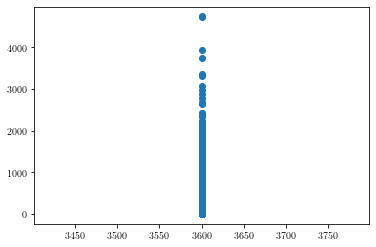

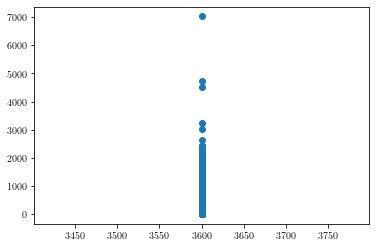

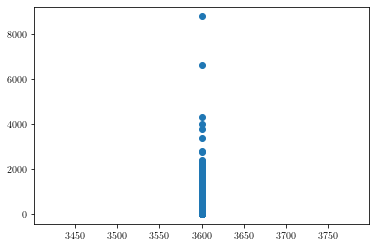

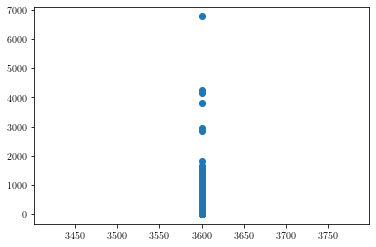

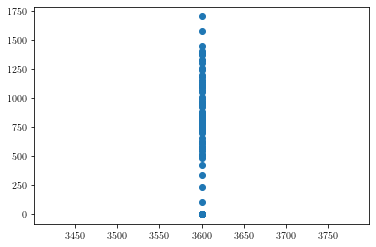

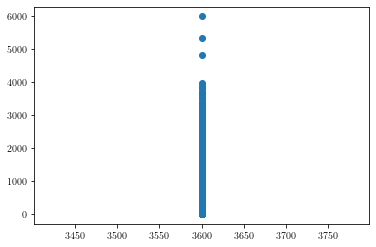

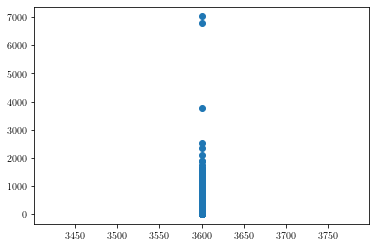

In [47]:
for expl in set(df_all_grows["explanation config"]):
    df_expl_config = df_all_grows[
#         (df_all_grows["params_grow_config"] == "Greedy MCSes + Actual + Unif.") &
        (df_all_grows["time_timedout"])&
        (df_all_grows["explanation config"] == expl)
#         (df_all_grows["params_instance"].isin(non_timedout_instances_incremental))
    ][["total_expl_cost", "time_totalTime"]]
    
    total_cost, total_time = [], []
    for _, row in df_expl_config.iterrows():
        total_cost.append(row["total_expl_cost"])
        total_time.append(row["time_totalTime"])
    plt.figure()
    plt.scatter(total_time,  total_cost, label=expl)
    

# Incremental vs non-incremental runtime plot

In [48]:
df_all_grows[
    df_all_grows["params_grow_config"] == 'SAT'
].groupby(by="explanation config").count()

,time_totalTime,time_timeout,time_timedout,time_explain,time_cumul_explain,time_preprocess,time_opt,time_sat,time_grow,time_disj_mcs,...,avg_t_explain,max_t_explain,min_t_explain,n_expls,%time_remaining_ocus,corr_explanation_config,incremental,HS,time_tavg_greedy_explain,time_to_first_expl
explanation config,,,,,,,,,,,,,,,,,,,,,
OCUS,403,403,403,403,403,403,403,403,403,403,...,399,403,403,403,403,403,403,403,0,0
OCUS+Incr. HS,403,403,403,403,403,403,403,403,403,403,...,397,403,403,403,403,403,403,403,0,0
OUS Iter.,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,0,0
OUS Iter.+Lit. Incr. HS,403,403,403,403,403,403,403,403,403,403,...,402,403,403,403,403,403,403,403,0,0
OUSb,403,403,403,403,403,403,403,403,403,403,...,315,403,403,403,403,403,403,403,0,0
OUSb+Lit. Incr. HS,403,403,403,403,403,403,403,403,403,403,...,315,403,403,403,403,403,403,403,0,0


In [49]:
set(df_all_grows["explanation config"])

{'MUS',
 'OCUS',
 'OCUS+Incr. HS',
 'OUS Iter.',
 'OUS Iter.+Lit. Incr. HS',
 'OUSb',
 'OUSb+Lit. Incr. HS'}

In [50]:
set(df_all_grows["params_grow_config"])

{'Disj.MCSes + Actual + Unif.',
 'Greedy MCSes + Actual + Unif.',
 'Greedy-Sat + Actual + Unif.',
 'MUS',
 'MaxSAT + Actual + Unif.',
 'MaxSAT + Full + Unif.',
 'SAT',
 'SAT MCSes + Actual + Unif.',
 'SUBSETMAX SAT MCSes + Actual + Unif.'}

/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/01_holygrail/latex/journal/jair21/figures/incremental_vs_non_SAT_2023_06_23.pdf


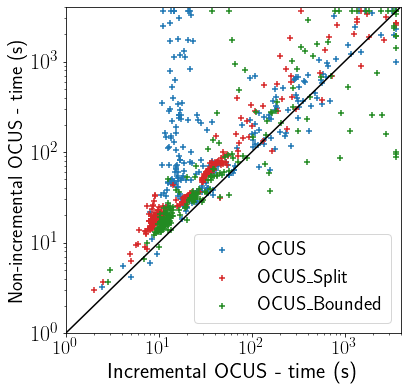

In [51]:
grow = 'SAT'
# grow = 'SAT MCSes + Actual + Unif.'
# fixing the grow: sat correction subset enumeration
df_sat_corr_grow = df_all_grows[
    df_all_grows["params_grow_config"] == grow
]

mapping_expl_config_incremental = {
    'OCUS': 'OCUS+Incr. HS',
    'OUS Iter.': 'OUS Iter.+Lit. Incr. HS',
    'OUSb': 'OUSb+Lit. Incr. HS'
}

label_mapping_expl_config = {
    'OCUS': 'OCUS',
    'OUS Iter.': 'OCUS\_Split',
    'OUSb': 'OCUS\_Bounded'
}

color_matching = {
    'OCUS': 'cornflowerblue',
    'OUS Iter.': 'tab:orange',
    'OUS Iter.+Lit. Incr. HS': 'tab:red',
    'OUSb': 'forestgreen',
    'MUS': 'tab:brown',
    'OUSb+Lit. Incr. HS': 'forestgreen',
    'OCUS+Incr. HS': 'tab:blue'
}


all_instances = set(df_sat_corr_grow["params_instance"])


plt.figure(figsize=(6,6))

for non_incremental_config, incremental_config in mapping_expl_config_incremental.items():
    non_incremental_times = []
    incremental_times = []
    for instance in all_instances:
        incremental_runtime = df_sat_corr_grow[
            (df_sat_corr_grow["params_instance"] == instance) &
            (df_sat_corr_grow["explanation config"] == incremental_config)
        ]["time_totalTime"]
        
        incremental_times.append(incremental_runtime)
        
        non_incremental_runtime = df_sat_corr_grow[
            (df_sat_corr_grow["params_instance"] == instance) &
            (df_sat_corr_grow["explanation config"] == non_incremental_config)
        ]["time_totalTime"]
        non_incremental_times.append(non_incremental_runtime)
    plt.scatter(
        incremental_times, 
        non_incremental_times, 
        marker='+',
        label=label_mapping_expl_config[non_incremental_config],
        color=color_matching[incremental_config]
    )

plt.plot(range(1, 4000, 100), range(1, 4000, 100), '-', color='black')
plt.xlim([1, 4000]);plt.ylim([1, 4000])
plt.xscale('log');plt.yscale('log')
plt.legend(loc="lower right", fontsize=20)
plt.xlabel('Incremental OCUS - time (s)', fontsize=22); plt.ylabel('Non-incremental OCUS - time (s)', fontsize=20)
plt.xticks(fontsize=20); plt.yticks(fontsize=22)



filepath = PATH_FIGURES_POST_PAPER / datetime.now().strftime(f"incremental_vs_non_{grow}_%Y_%m_%d.pdf")
print(filepath)
plt.savefig(
    PATH_FIGURES_POST_PAPER / datetime.now().strftime(f"incremental_vs_non_{grow}_%Y_%m_%d.pdf"),bbox_inches ="tight",
            transparent = True
)